# F1 Predict Project

<img src = "./Pic.jpg"></img>

The Formula-1 weekend consists of 3 major stages:

- Friday and Saturday practice sessions
- Saturday qualification session
- Sunday race

Practices are used to learn the track, tune the car properly and practice the setup. Drivers just pass as many laps as they wish in any order. Final protocol counts only the best lap time for each driver. Though it is not counted anywhere during the race weekend. There are three sessions, which does not differ much.

Qualification session looks a lot like practice, but it's result determines the starting order of the drivers in Sunday race. The session is split in 3 segments: 

- In the first one all drivers try to set up the best lap time they can. After 20 minutes the last 5 in best lap time list are eliminated
- In the second segment the rest 15 fight from the beginning to get through to the third segment. The last 5 is eliminated
- In the third segment top-10 drivers compete to get the highest place on the starting grid of the race. The quickest one starts from the first place, the second one - from the second and so on.

In the race all the drivers start together in order determined in qualification. They race fixed amount of laps.

The goal of the project is to build a binary classifier, which predicts if a driver finishes in top-10 in upcoming race.

## Data import

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import lightgbm as lgb
import xgboost as xgb
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import learning_curve

%matplotlib inline

In [69]:
# Racing stats

race = pd.read_csv('Race_base.csv', names = ['pos', 'no', 'driver', 'team', 'laps', 
                                             'time', 'points', 'race_no', 'season', 'track'], skiprows = [0])
race.drop(['no', 'points'], axis = 1, inplace = True)
race.head()

,pos,driver,team,laps,time,race_no,season,track
0,1,Sebastian Vettel,FERRARI,57,1:24:11.672,1,2017,Albert Park
1,2,Lewis Hamilton,MERCEDES,57,+9.975s,1,2017,Albert Park
2,3,Valtteri Bottas,MERCEDES,57,+11.250s,1,2017,Albert Park
3,4,Kimi Räikkönen,FERRARI,57,+22.393s,1,2017,Albert Park
4,5,Max Verstappen,RED BULL RACING TAG HEUER,57,+28.827s,1,2017,Albert Park


In [70]:
# Qualification results dataset

qual = pd.read_csv('Quali_base.csv', names = ['pos', 'no', 'driver', 'team', 'q1', 'q2', 'q3', 'laps', 'race_no', 'season', 'track'],
                   skiprows = [0])
qual.drop('no', axis = 1, inplace = True)
qual.head()

,pos,driver,team,q1,q2,q3,laps,race_no,season,track
0,1,Lewis Hamilton,MERCEDES,1:24.191,1:23.251,1:22.188,14,1,2017,Albert Park
1,2,Sebastian Vettel,FERRARI,1:25.210,1:23.401,1:22.456,17,1,2017,Albert Park
2,3,Valtteri Bottas,MERCEDES,1:24.514,1:23.215,1:22.481,13,1,2017,Albert Park
3,4,Kimi Räikkönen,FERRARI,1:24.352,1:23.376,1:23.033,19,1,2017,Albert Park
4,5,Max Verstappen,RED BULL RACING TAG HEUER,1:24.482,1:24.092,1:23.485,18,1,2017,Albert Park


In [71]:
# Practice sessions results dataset

prac = pd.read_csv('Practice_base.csv', names = ['pos', 'no', 'driver', 'team', 'time', 'gap', 'laps', 'session', 'race_no', 'season', 'track'],
                  skiprows = [0])
prac.drop('no', axis = 1, inplace = True)
prac.head()

,pos,driver,team,time,gap,laps,session,race_no,season,track
0,1,Lewis Hamilton,MERCEDES,1:24.220,NaN,22.0,P1,1,2017,Albert Park
1,2,Valtteri Bottas,MERCEDES,1:24.803,+0.583s,25.0,P1,1,2017,Albert Park
2,3,Daniel Ricciardo,RED BULL RACING TAG HEUER,1:24.886,+0.666s,19.0,P1,1,2017,Albert Park
3,4,Max Verstappen,RED BULL RACING TAG HEUER,1:25.246,+1.026s,19.0,P1,1,2017,Albert Park
4,5,Kimi Räikkönen,FERRARI,1:25.372,+1.152s,16.0,P1,1,2017,Albert Park


## Procedures

In [72]:
# Fix team names for qualifying and practice datasets

# Rename teams to unified pattern
# Proceeding nicely, putting manufacturer's team in the end, as all teams contain engine in the name

def team_name(dataset):

    dataset.loc[dataset['team'].str.contains('SAUBER'), 'team'] = 'Sauber'
    dataset.loc[dataset['team'].str.contains('FORCE'), 'team'] = 'Force India'
    dataset.loc[dataset['team'].str.contains('TORO'), 'team'] = 'Toro Rosso'
    dataset.loc[dataset['team'].str.contains('MCLAREN'), 'team'] = 'Mclaren'
    dataset.loc[dataset['team'].str.contains('HAAS'), 'team'] = 'Haas'
    dataset.loc[dataset['team'].str.contains('WILLIAMS'), 'team'] = 'Williams'
    dataset.loc[dataset['team'].str.contains('STR'), 'team'] = 'Toro Rosso'
    dataset.loc[dataset['team'].str.contains('BULL'), 'team'] = 'Red Bull'
    dataset.loc[dataset['team'].str.contains('|'.join(['MARUSSIA', 'MRT'])), 'team'] = 'Marussia'
    dataset.loc[dataset['team'].str.contains('LOTUS'), 'team'] = 'Lotus'
    dataset.loc[dataset['team'].str.contains('FERRARI'), 'team'] = 'Ferrari'
    dataset.loc[dataset['team'].str.contains('RENAULT'), 'team'] = 'Renault'
    dataset.loc[dataset['team'].str.contains('MERCEDES'), 'team'] = 'Mercedes'
    
    return dataset

## Race feature engineering

In [73]:
race['team'].value_counts()

MERCEDES                     138
FERRARI                      138
FORCE INDIA MERCEDES         138
SAUBER FERRARI               138
WILLIAMS MERCEDES            137
MCLAREN HONDA                120
HAAS FERRARI                 100
RENAULT                      100
RED BULL RACING TAG HEUER    100
TORO ROSSO FERRARI            42
MRT MERCEDES                  42
TORO ROSSO                    40
RED BULL RACING RENAULT       38
LOTUS MERCEDES                38
STR RENAULT                   38
MARUSSIA FERRARI              35
SCUDERIA TORO ROSSO HONDA     18
MCLAREN RENAULT               18
Name: team, dtype: int64

In [74]:
# Separate engine supplier
# Setting Red Bull's Tag Heuer in 2018 as Renault (it is)
# Setting Toro Rosso's 2017 "no engine" as Renault (it is)

race['engine'] = '-'
race.loc[race['team'].str.contains('FERRARI'), 'engine'] = 'Ferrari'
race.loc[race['team'].str.contains('MERCEDES'), 'engine'] = 'Mercedes'
race.loc[race['team'].str.contains('|'.join(['RENAULT', 'TAG'])), 'engine'] = 'Renault'
race.loc[race['team'].str.contains('HONDA'), 'engine'] = 'Honda'
race.loc[race['team'] == 'TORO ROSSO', 'engine'] = 'Renault'

race['engine'].value_counts()

Mercedes    493
Ferrari     453
Renault     334
Honda       138
Name: engine, dtype: int64

In [75]:
# Rename teams to unified pattern

race = team_name(race)

In [76]:
race['team'].value_counts()

Mercedes       138
Mclaren        138
Red Bull       138
Force India    138
Toro Rosso     138
Ferrari        138
Sauber         138
Williams       137
Renault        100
Haas           100
Marussia        77
Lotus           38
Name: team, dtype: int64

In [77]:
# Calculating distance passed before withdrawal
# Those finished the race in several laps behind the winner are considered passed 100% distance

race['distance'] = 0
races = [x for x in range(1, 22)]
seasons = [2015, 2016, 2017, 2018]

for s in seasons:
    for r in races:
        race.loc[(race['season'] == s) & (race['race_no'] == r) & (race['time'] != 'DNF'), 'distance'] = 1
        laps = race.loc[(race['season'] == s) & (race['race_no'] == r) & (race['time'] == 'DNF'), 'laps'].values
        overall_laps = race.loc[(race['season'] == s) & (race['race_no'] == r) & (race['pos'] == 1), 'laps'].values
        race.loc[(race['season'] == s) & (race['race_no'] == r) & (race['time'] == 'DNF'), 'distance'] = laps / overall_laps

In [78]:
race.head(20)

,pos,driver,team,laps,time,race_no,season,track,engine,distance
0,1,Sebastian Vettel,Ferrari,57,1:24:11.672,1,2017,Albert Park,Ferrari,1.000000
1,2,Lewis Hamilton,Mercedes,57,+9.975s,1,2017,Albert Park,Mercedes,1.000000
2,3,Valtteri Bottas,Mercedes,57,+11.250s,1,2017,Albert Park,Mercedes,1.000000
3,4,Kimi Räikkönen,Ferrari,57,+22.393s,1,2017,Albert Park,Ferrari,1.000000
4,5,Max Verstappen,Red Bull,57,+28.827s,1,2017,Albert Park,Renault,1.000000
5,6,Felipe Massa,Williams,57,+83.386s,1,2017,Albert Park,Mercedes,1.000000
6,7,Sergio Perez,Force India,56,+1 lap,1,2017,Albert Park,Mercedes,1.000000
7,8,Carlos Sainz,Toro Rosso,56,+1 lap,1,2017,Albert Park,Renault,1.000000
8,9,Daniil Kvyat,Toro Rosso,56,+1 lap,1,2017,Albert Park,Renault,1.000000
9,10,Esteban Ocon,Force India,56,+1 lap,1,2017,Albert Park,Mercedes,1.000000


## Qualification feature engineering

In [79]:
# Fix team names for qualifying and practice datasets

qual = team_name(qual)

In [80]:
# Adding features for 2nd and 3rd quali segments if driver made through

qual['is_q2'] = 0
qual['is_q3'] = 0
qual.loc[~qual['q2'].isna(), 'is_q2'] = 1
qual.loc[~qual['q3'].isna(), 'is_q3'] = 1

In [81]:
# Calculating quali best time for driver

races = [x for x in range(1, 22)]
seasons = [2015, 2016, 2017, 2018]

qual.loc[qual['q1'].isna(), 'q1'] = '10:00.000'
qual.drop(qual[qual['q1'] == '10:00.000'].index, inplace = True)
qual.loc[qual['q2'].isna(), 'q2'] = '10:00.000'
qual.loc[qual['q3'].isna(), 'q3'] = '10:00.000'

# Calculating all quali times in seconds
quali_times = []
for q_segment in ['q1', 'q2', 'q3']:
    qual.loc[qual[q_segment].str.contains('|'.join(['DNF', 'DNS'])), q_segment] = '10:00.000'
    q_res = [datetime.strptime(x, '%M:%S.%f') for x in qual[q_segment].values]
    q_sec = [a.minute * 60 + a.second + a.microsecond / 1000000 for a in q_res]
    new_seg = q_segment + '_sec'
    quali_times.append(q_sec)
    qual[new_seg] = q_sec
    
# Choosing the fastest time for a drive in all segments
times_per_driver = [min(a, b, c) for a, b, c in zip(quali_times[0], quali_times[1], quali_times[2])]
qual['best_time'] = times_per_driver

for s in seasons:
    for r in races:
        if len(qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'best_time']) > 0:
            qual.loc[(qual['race_no'] == r) & (qual['season'] == s) & (qual['q1'] == '10:00.000'), 
                     'best_time'] = max(qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'best_time']) * 1.01
            qual.drop(qual[qual['q1'] == '10:00.000'].index, inplace = True)

In [82]:
# Best time leader gap (share, here and below)

# !!! CLEAN THE MEMORY AFTER ARRANGING TO FUNCTIONS

races = [x for x in range(1, 22)]
seasons = [2015, 2016, 2017, 2018]

qual['leader_gap'] = 0
for s in seasons:
    for r in races:
        leader = qual[(qual['pos'] == 1) & (qual['race_no'] == r) & (qual['season'] == s)]['best_time'].values
        gaps = [(x - leader) / leader for x in qual[(qual['race_no'] == r) & 
                                                    (qual['season'] == s)]['best_time'].values]
        qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'leader_gap'] = gaps

# Best time front gap

# !! TRY TO CHECK GAP BEHIND

qual['front_gap'] = 0
qual['best_time_order'] = 0
for s in seasons:
    for r in races:
        real_order = pd.DataFrame({'best_time': qual[(qual['race_no'] == r) & 
                                                     (qual['season'] == s)]['best_time'].values, 
                                   'pos': qual[(qual['race_no'] == r) & (qual['season'] == s)]['pos'].values})
        real_order = real_order.sort_values(by = 'best_time').reset_index(drop = True)
        real_order['best_time_pos'] = [x + 1 for x in real_order.index.tolist()]
        
        time_front = real_order['best_time'].values
        gaps = [0]
        for i in range(1, real_order.shape[0]):
            gaps.append((time_front[i] - time_front[i - 1]) / time_front[i - 1])
        real_order['front_gap'] = gaps
        
        old_order = real_order.sort_values(by = 'pos').reset_index()
        front_gaps = old_order['front_gap'].values
        best_time_order = [x + 1 for x in old_order['index'].values]
        
        qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'front_gap'] = front_gaps
        qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'best_time_order'] = best_time_order

# Best time median ahead and behind gap

qual['median_ahead'] = 0
qual['median_behind'] = 0
for s in seasons:
    for r in races:
        race_df = qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 
                           ['best_time', 'best_time_order', 'front_gap', 'pos']]
        race_df = race_df.sort_values(by = ['best_time']).reset_index(drop = True)
        
        if race_df.shape[0] > 0:
        
            # Medians ahead

            medians = [0, race_df.iloc[1]['front_gap'] / 2]
            for i in range(2, race_df.shape[0]):
                times = race_df.iloc[:i]['best_time'].values
                medians.append(race_df.iloc[i]['best_time'] - np.median(times))

            race_df['medians_ahead'] = medians    

            #  Medians behind

            medians = []

            for i in range(race_df.shape[0] - 2):
                times = race_df.iloc[i + 1:]['best_time'].values
                medians.append(race_df.iloc[i]['best_time'] - np.median(times))

            medians.append((race_df.iloc[race_df.shape[0] - 2]['best_time'] - race_df.iloc[race_df.shape[0] - 1]
                            ['best_time']) / 2)
            medians.append(0)

            race_df['medians_behind'] = medians

            old_order = race_df.sort_values(by = 'pos').reset_index(drop = True)
            median_ahead = old_order['medians_ahead'].values
            median_behind = old_order['medians_behind'].values
            qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'median_ahead'] = median_ahead
            qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'median_behind'] = median_behind

In [83]:
qual.shape

(1397, 21)

In [84]:
# Now we need to add mean team result, mean result for the last 3 and 5 races (driver and team)

# First mean team result in current race

qual['team_avg'] = 0
for s in seasons:
    for r in races:
        race_df = qual.loc[(qual['race_no'] == r) & (qual['season'] == s), ['team', 'best_time_order']]
        
        if race_df.shape[0] > 0:
            
            race_df['team_avg'] = 0
            for team in race_df['team'].unique():
                race_df.loc[race_df['team'] == team, 
                            'team_avg'] = race_df[race_df['team'] == team]['best_time_order'].mean()
            team = race_df['team_avg'].values
            qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'team_avg'] = team
            
# Mean team result for the last 3 and 5 races

qual['team_last_3'] = 0
qual['team_last_5'] = 0
for s in seasons:
    for r in races:
        
        if r == 1:
            qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 
                     'team_last_3'] = prac.loc[(prac['race_no'] == r) & (prac['season'] == s) & (prac['session'] == 'P3'), 'pos']
            qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 
                     'team_last_5'] = prac.loc[(prac['race_no'] == r) & (prac['season'] == s) & (prac['session'] == 'P3'), 'pos']
            continue
        elif r == 2:
            set_3 = [1]
            set_5 = [1]
        elif r == 3:
            set_3 = [1, 2]
            set_5 = [1, 2]
        elif r == 4:
            set_3 = [1, 2, 3]
            set_5 = [1, 2, 3]
        elif r == 5:
            set_3 = [2, 3, 4]
            set_5 = [1, 2, 3, 4]
        else:
            set_3 = [r - i for i in range(1, 4)]
            set_5 = [r - i for i in range(1, 6)]
            
        race_set_3 = qual.loc[(qual['race_no'].isin(set_3)) & (qual['season'] == s), ['team', 'best_time_order']]
        race_set_5 = qual.loc[(qual['race_no'].isin(set_5)) & (qual['season'] == s), ['team', 'best_time_order']]
        
        race_df = qual.loc[(qual['race_no'] == r) & (qual['season'] == s), ['team', 'best_time_order']]
        
        if race_df.shape[0] > 0:
            
            race_df['team_last_3'] = 0
            race_df['team_last_5'] = 0
            for team in race_df['team'].unique():
                race_df.loc[race_df['team'] == team, 
                            'team_last_3'] = race_set_3[race_set_3['team'] == team]['best_time_order'].mean()
                race_df.loc[race_df['team'] == team, 
                            'team_last_5'] = race_set_5[race_set_5['team'] == team]['best_time_order'].mean()
            team_3 = race_df['team_last_3'].values
            team_5 = race_df['team_last_5'].values
            qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'team_last_3'] = team_3
            qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'team_last_5'] = team_5
            
# Mean driver result for the last 3 and 5 races

qual['last_3'] = 0
qual['last_5'] = 0
for s in seasons:
    for r in races:
        
        if r == 1:
            qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 
                     'last_3'] = qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'best_time_order']
            qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 
                     'last_5'] = qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'best_time_order']
            continue
        elif r == 2:
            set_3 = [1]
            set_5 = [1]
        elif r == 3:
            set_3 = [1, 2]
            set_5 = [1, 2]
        elif r == 4:
            set_3 = [1, 2, 3]
            set_5 = [1, 2, 3]
        elif r == 5:
            set_3 = [2, 3, 4]
            set_5 = [1, 2, 3, 4]
        else:
            set_3 = [r - i for i in range(1, 4)]
            set_5 = [r - i for i in range(1, 6)]            
            
        race_set_3 = qual.loc[(qual['race_no'].isin(set_3)) & (qual['season'] == s), ['driver', 'best_time_order']]
        race_set_5 = qual.loc[(qual['race_no'].isin(set_5)) & (qual['season'] == s), ['driver', 'best_time_order']]
        
        race_df = qual.loc[(qual['race_no'] == r) & (qual['season'] == s), ['driver', 'best_time_order']]
        
        if race_df.shape[0] > 0:
            
            race_df['last_3'] = 0
            race_df['last_5'] = 0
            for driver in race_df['driver'].unique():
                race_df.loc[race_df['driver'] == driver, 
                            'last_3'] = race_set_3[race_set_3['driver'] == driver]['best_time_order'].mean()
                race_df.loc[race_df['driver'] == driver, 
                            'last_5'] = race_set_5[race_set_5['driver'] == driver]['best_time_order'].mean()
            driver_3 = race_df['last_3'].values
            driver_5 = race_df['last_5'].values
            
            qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'last_3'] = driver_3
            qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'last_5'] = driver_5

## Practice feature engineering

In [85]:
# Fix team names

prac = team_name(prac)

<strike>1. Time to seconds for P1, P2, P3</strike>

<strike>2. Leader gap for P1, P2, P3</strike>

<strike>3. Front gap for P1, P2, P3 (gap behind?)</strike>

<strike>4. Position for P1, P2, P3</strike>

<strike>5. Team average position for P1, P2, P3</strike>

<strike>6. Median ahead for P1, P2, P3 (check the difference)</strike>

<strike>7. Median behind for P1, P2, P3 (check the difference)</strike>

- What do we do with the guys, who missed the session (laps < 5)?
"Missing" values for 
                     P3 is 46
                     P2 is 23
                     P1 is 39
Intersected only 1 driver in 2 sessions during 1 weekend.

In [86]:
prac.shape

(4182, 10)

In [87]:
# Check practice failure intersection

fail = prac[((prac['gap'].isna()) | (prac['laps'] < 4)) & (prac['pos'] != 1)]
fail = fail.groupby(['season', 'race_no', 'session', 'driver']).count()
fail

pos  team  time  gap  laps  track
season race_no session driver                                              
2015   2       P1      Lewis Hamilton       1     1     0    0     1      1
       3       P3      Fernando Alonso      1     1     0    0     1      1
       4       P1      Jenson Button        1     1     0    0     1      1
       7       P3      Fernando Alonso      1     1     1    1     1      1
       10      P1      Jolyon Palmer        1     1     0    0     1      1
       11      P3      Fernando Alonso      1     1     0    0     1      1
       12      P2      Jenson Button        1     1     1    1     1      1
       13      P2      Will Stevens         1     1     1    1     1      1
       14      P1      Alexander Rossi      1     1     0    0     1      1
                       Daniel Ricciardo     1     1     0    0     1      1
                       Fernando Alonso      1     1     0    0     1      1
                       Jolyon Palmer        1     1     0    0     1      1
                       Nico Hulkenberg      1     1     0    0     1      1
                       Pastor Maldonado     1     1     0    0     1      1
                       Sergio Perez         1     1     0    0     1      1
                       Will Stevens         1     1     0    0     1      1
       16      P1      Pastor Maldonado     1     1     0    0     1      1
       17      P2      Max Verstappen       1     1     0    0     1      1
       19      P3      Daniil Kvyat         1     1     0    0     1      1
2016   1       P1      Carlos Sainz         1     1     0    0     1      1
                       Sebastian Vettel     1     1     0    0     1      1
               P2      Felipe Massa         1     1     0    0     1      1
                       Jolyon Palmer        1     1     0    0     1      1
                       Kevin Magnussen      1     1     0    0     1      1
                       Valtteri Bottas      1     1     0    0     1      1
       3       P1      Esteban Gutierrez    1     1     0    0     1      1
                       Felipe Massa         1     1     0    0     1      1
                       Kevin Magnussen      1     1     0    0     1      1
               P2      Kevin Magnussen      1     1     0    0     0      1
               P3      Daniel Ricciardo     1     1     0    0     1      1
...                                       ...   ...   ...  ...   ...    ...
2017   16      P2      Fernando Alonso      1     1     0    0     1      1
                       Jolyon Palmer        1     1     0    0     1      1
                       Kimi Räikkönen       1     1     0    0     1      1
                       Marcus Ericsson      1     1     0    0     1      1
                       Nico Hulkenberg      1     1     0    0     1      1
                       Pascal Wehrlein      1     1     0    0     1      1
                       Sebastian Vettel     1     1     0    0     1      1
                       Sergio Perez         1     1     1    1     1      1
                       Stoffel Vandoorne    1     1     0    0     1      1
       17      P1      Fernando Alonso      1     1     0    0     1      1
       18      P1      Stoffel Vandoorne    1     1     0    0     1      1
               P2      Romain Grosjean      1     1     1    1     1      1
               P3      Pierre Gasly         1     1     0    0     1      1
       19      P1      Brendon Hartley      1     1     0    0     1      1
               P3      Lance Stroll         1     1     0    0     1      1
2018   1       P3      Esteban Ocon         1     1     0    0     1      1
                       Sergio Perez         1     1     0    0     1      1
       2       P1      Max Verstappen       1     1     0    0     1      1
       7       P1      Nico Hulkenberg      1     1     0    0     1      1
       8       P2      Marcus Ericsson      1     1     1    1     1      1
              

In [88]:
prac.loc[prac['time'].isna(), 'time'] = '10:00.000'

# Calculating all practice times in seconds

prac.loc[(prac['time'].str.contains('|'.join(['DNF', 'DNS'])) | (prac['time'] == '0')), 'time'] = '10:00.000'
pr_res = [datetime.strptime(x, '%M:%S.%f') for x in prac['time'].values]
pr_sec = [a.minute * 60 + a.second + a.microsecond / 1000000 for a in pr_res]
prac['time_sec'] = pr_sec

In [89]:
# Extracting separately info for P1, P2 and P3. Adding time in seconds and session position

pr1 = prac[prac['session'] == 'P1']
pr2 = prac[prac['session'] == 'P2']
pr3 = prac[prac['session'] == 'P3']

In [90]:
# Session leader gap share

races = prac['race_no'].unique()
seasons = prac['season'].unique()

sessions = [pr1, pr2, pr3]
for df in sessions:
    df.loc[:, 'leader_gap'] = 0
    for s in seasons:
        for r in races:
            leader = df[(df['pos'] == 1) & (df['race_no'] == r) & (df['season'] == s)]['time_sec'].values
            gaps = [(x - leader) / leader for x in df[(df['race_no'] == r) & 
                                                        (df['season'] == s)]['time_sec'].values]
            df.loc[(df['race_no'] == r) & (df['season'] == s), 'leader_gap'] = gaps
            
# Front car gap share

for df in sessions:
    
    df.loc[:, 'front_gap'] = 0

    for s in seasons:
        for r in races:          
            time_front = df[(df['race_no'] == r) & (df['season'] == s)]['time_sec'].values
            gaps = [0]
            for i in range(1, len(time_front)):
                gaps.append((time_front[i] - time_front[i - 1]) / time_front[i - 1])

            df.loc[(df['race_no'] == r) & (df['season'] == s), 'front_gap'] = gaps

# Team mean session position

for df in sessions:
    
    df.loc[:, 'team_avg'] = 0

    for s in seasons:
        for r in races:
            race_df = df.loc[(df['race_no'] == r) & (df['season'] == s), ['team', 'pos']]

            if race_df.shape[0] > 0:

                race_df.loc[:, 'team_avg'] = 0
                for team in race_df['team'].unique():
                    race_df.loc[race_df['team'] == team, 
                                'team_avg'] = race_df[race_df['team'] == team]['pos'].mean()
                team = race_df['team_avg'].values
                df.loc[(df['race_no'] == r) & (df['season'] == s), 'team_avg'] = team
                
# Best time median ahead and behind gap

for df in sessions:
    
    df.loc[:, 'median_ahead'] = 0
    df.loc[:, 'median_behind'] = 0

    for s in seasons:
        for r in races:
            race_df = df.loc[(df['race_no'] == r) & (df['season'] == s), 
                               ['time_sec', 'front_gap', 'pos']]

            if race_df.shape[0] > 0:

                # Medians ahead

                medians_ahead = [0, race_df.iloc[1]['front_gap'] / 2]
                for i in range(2, race_df.shape[0]):
                    times = race_df.iloc[:i]['time_sec'].values
                    medians_ahead.append(race_df.iloc[i]['time_sec'] - np.median(times))

                #  Medians behind

                medians_behind = []

                for i in range(race_df.shape[0] - 2):
                    times = race_df.iloc[i + 1:]['time_sec'].values
                    medians_behind.append(race_df.iloc[i]['time_sec'] - np.median(times))

                medians_behind.append((race_df.iloc[race_df.shape[0] - 2]
                                       ['time_sec'] - race_df.iloc[race_df.shape[0] - 1]['time_sec']) / 2)
                medians_behind.append(0)

                df.loc[(df['race_no'] == r) & (df['season'] == s), 'median_ahead'] = medians_ahead
                df.loc[(df['race_no'] == r) & (df['season'] == s), 'median_behind'] = medians_behind

D:\Soft\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\Soft\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Merging datasets

In [91]:
# Separating names for practice datasets

pr1 = pr1.rename(index = str, columns = {'pos': 'P1_pos',
                                        'laps': 'P1_laps',
                                        'time_sec': 'P1_time',
                                        'leader_gap': 'P1_leader_gap',
                                        'front_gap': 'P1_front_gap',
                                        'team_avg': 'P1_team_avg',
                                        'median_ahead': 'P1_median_ahead',
                                        'median_behind': 'P1_median_behind'})
pr2 = pr2.rename(index = str, columns = {'pos': 'P2_pos',
                                        'laps': 'P2_laps',
                                        'time_sec': 'P2_time',
                                        'leader_gap': 'P2_leader_gap',
                                        'front_gap': 'P2_front_gap',
                                        'team_avg': 'P2_team_avg',
                                        'median_ahead': 'P2_median_ahead',
                                        'median_behind': 'P2_median_behind'})
pr3 = pr3.rename(index = str, columns = {'pos': 'P3_pos',
                                        'laps': 'P3_laps',
                                        'time_sec': 'P3_time',
                                        'leader_gap': 'P3_leader_gap',
                                        'front_gap': 'P3_front_gap',
                                        'team_avg': 'P3_team_avg',
                                        'median_ahead': 'P3_median_ahead',
                                        'median_behind': 'P3_median_behind'})
pr1 = pr1.drop(['time', 'gap', 'session', 'track'], axis = 1)
pr2 = pr2.drop(['time', 'gap', 'session', 'track'], axis = 1)
pr3 = pr3.drop(['time', 'gap', 'session', 'track'], axis = 1)

In [92]:
# Merging practice, and qualification sets

pr32 = pr3.merge(pr2, on = ['driver', 'team', 'race_no', 'season'], how = 'outer')

fpr = pr32.merge(pr1, on = ['driver', 'team', 'race_no', 'season'], how = 'outer')

df = qual.merge(fpr, on = ['driver', 'team', 'race_no', 'season'], how = 'left')

In [93]:
df = df.rename(index = str, columns = {'pos': 'Q_pos', 'laps': 'Q_laps'})
df = df.drop(['track'], axis = 1)

In [94]:
print(qual.shape)
print(fpr.shape)
print(df.shape)

(1397, 26)
(1487, 28)
(1397, 49)


In [95]:
# Merging with race dataset

data = race.merge(df, on = ['driver', 'team', 'race_no', 'season'], how = 'left')

In [96]:
data.shape

(1418, 55)

## Cleaning and fixing dataset

In [97]:
# Empty qualifying position. The 3 drivers only participated in race, so they are very unstable as objects
# Dropping

data[data['Q_pos'].isna()][['pos', 'driver', 'team', 'race_no', 'season', 'Q_pos', 'P1_pos', 'P2_pos', 'P3_pos']]
data = data.drop(data[data['Q_pos'].isna()].index)

In [98]:
# Team_last_3 and 5 missing only one value for the first Marussia race. Setting as Q_pos
# Check if we drop quali results, this feature should be rearranged to avoid leaks

data.loc[data['team_last_3'].isna(), 'team_last_3'] = data.loc[data['team_last_3'].isna(), 'team_avg']
data.loc[data['team_last_5'].isna(), 'team_last_5'] = data.loc[data['team_last_5'].isna(), 'team_avg']

# Last 3 and 5 races results might be empty if the driver has one race in the middle of the season.
# Setting as Q_pos
# Check if we drop quali results, this feature should be rearranged to avoid leaks

data.loc[data['last_5'].isna(), 'last_5'] = data.loc[data['last_5'].isna(), 'Q_pos']
data.loc[data['last_3'].isna(), 'last_3'] = data.loc[data['last_3'].isna(), 'Q_pos']

# If the driver misses all the practice sessions, we can't rely on the data. For the set it's only one line

data = data.drop(data[(data['P3_pos'].isna()) & (data['P2_pos'].isna()) & (data['P1_pos'].isna())].index)

# Practice sessions results may be abscent when it was raining and the driver decided not to go out
# Or if it was cricital technical problem. Grounding these results would descrease quality.
# There are no NA 3rd practice sessions. Intersection between P1 and P2 consists only of 4 objects
# So substitute NA with P3 result

data.loc[data['P2_pos'].isna(), 'P2_pos'] = data.loc[data['P2_pos'].isna(), 'P3_pos']
data.loc[data['P2_laps'].isna(), 'P2_laps'] = data.loc[data['P2_laps'].isna(), 'P3_laps']
data.loc[data['P2_time'].isna(), 'P2_time'] = data.loc[data['P2_time'].isna(), 'P3_time']
data.loc[data['P2_leader_gap'].isna(), 'P2_leader_gap'] = data.loc[data['P2_leader_gap'].isna(), 'P3_leader_gap']
data.loc[data['P2_front_gap'].isna(), 'P2_front_gap'] = data.loc[data['P2_front_gap'].isna(), 'P3_front_gap']
data.loc[data['P2_team_avg'].isna(), 'P2_team_avg'] = data.loc[data['P2_team_avg'].isna(), 'P3_team_avg']
data.loc[data['P2_median_ahead'].isna(), 'P2_median_ahead'] = data.loc[data['P2_median_ahead'].isna(), 'P3_median_ahead']
data.loc[data['P2_median_behind'].isna(), 'P2_median_behind'] = data.loc[data['P2_median_behind'].isna(), 'P3_median_behind']
data.loc[data['P1_pos'].isna(), 'P1_pos'] = data.loc[data['P1_pos'].isna(), 'P3_pos']
data.loc[data['P1_laps'].isna(), 'P1_laps'] = data.loc[data['P1_laps'].isna(), 'P3_laps']
data.loc[data['P1_time'].isna(), 'P1_time'] = data.loc[data['P1_time'].isna(), 'P3_time']
data.loc[data['P1_leader_gap'].isna(), 'P1_leader_gap'] = data.loc[data['P1_leader_gap'].isna(), 'P3_leader_gap']
data.loc[data['P1_front_gap'].isna(), 'P1_front_gap'] = data.loc[data['P1_front_gap'].isna(), 'P3_front_gap']
data.loc[data['P1_team_avg'].isna(), 'P1_team_avg'] = data.loc[data['P1_team_avg'].isna(), 'P3_team_avg']
data.loc[data['P1_median_ahead'].isna(), 'P1_median_ahead'] = data.loc[data['P1_median_ahead'].isna(), 'P3_median_ahead']
data.loc[data['P1_median_behind'].isna(), 'P1_median_behind'] = data.loc[data['P1_median_behind'].isna(), 'P3_median_behind']

# One NaN for P3 laps

data.loc[data['P3_laps'].isna(), 'P3_laps'] = 0

## Visualization

In [99]:
from scipy.stats import gaussian_kde
import seaborn as sns

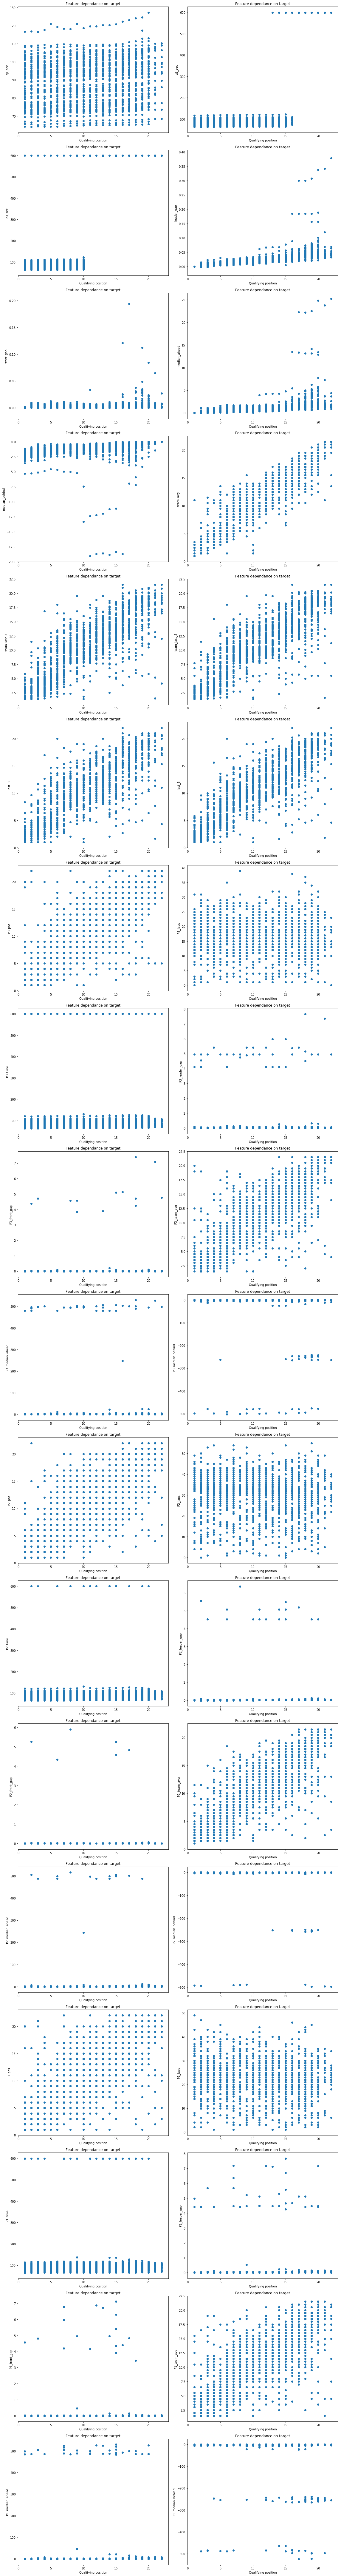

In [100]:
# Visualizing dependancies for all countable features for target feature (Q_pos)

features = ['q1_sec', 'q2_sec', 'q3_sec', 'leader_gap', 'front_gap', 'median_ahead', 'median_behind',
           'team_avg', 'team_last_3', 'team_last_5', 'last_3', 'last_5', 'P3_pos', 'P3_laps', 'P3_time', 
            'P3_leader_gap', 'P3_front_gap', 'P3_team_avg', 'P3_median_ahead', 'P3_median_behind', 'P2_pos', 
            'P2_laps', 'P2_time', 'P2_leader_gap', 'P2_front_gap', 'P2_team_avg', 'P2_median_ahead',
           'P2_median_behind', 'P1_pos', 'P1_laps', 'P1_time', 'P1_leader_gap', 'P1_front_gap', 'P1_team_avg', 
            'P1_median_ahead', 'P1_median_behind']

figure, axes = plt.subplots(nrows = 18, ncols = 2, figsize = (16, 120))

i = 0
for rows in axes:  
    for ax1 in rows:
        ax1.scatter(data['Q_pos'].values, data[features[i]].values)
        ax1.set_ylabel(features[i])
        ax1.set_xlabel('Qualifying position')
        ax1.set_title('Feature dependance on target')
        i += 1

plt.tight_layout()
plt.show()

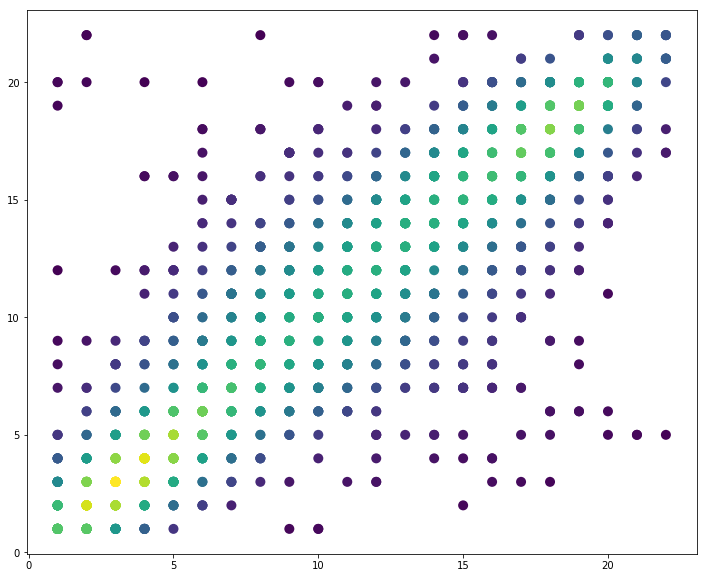

In [101]:
fig = plt.figure(figsize = (12, 10))

x = data['Q_pos'].values
y = data['P3_pos']

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

plt.scatter(x, y, c = z, s = 100, edgecolor = '')
plt.show()

D:\Soft\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


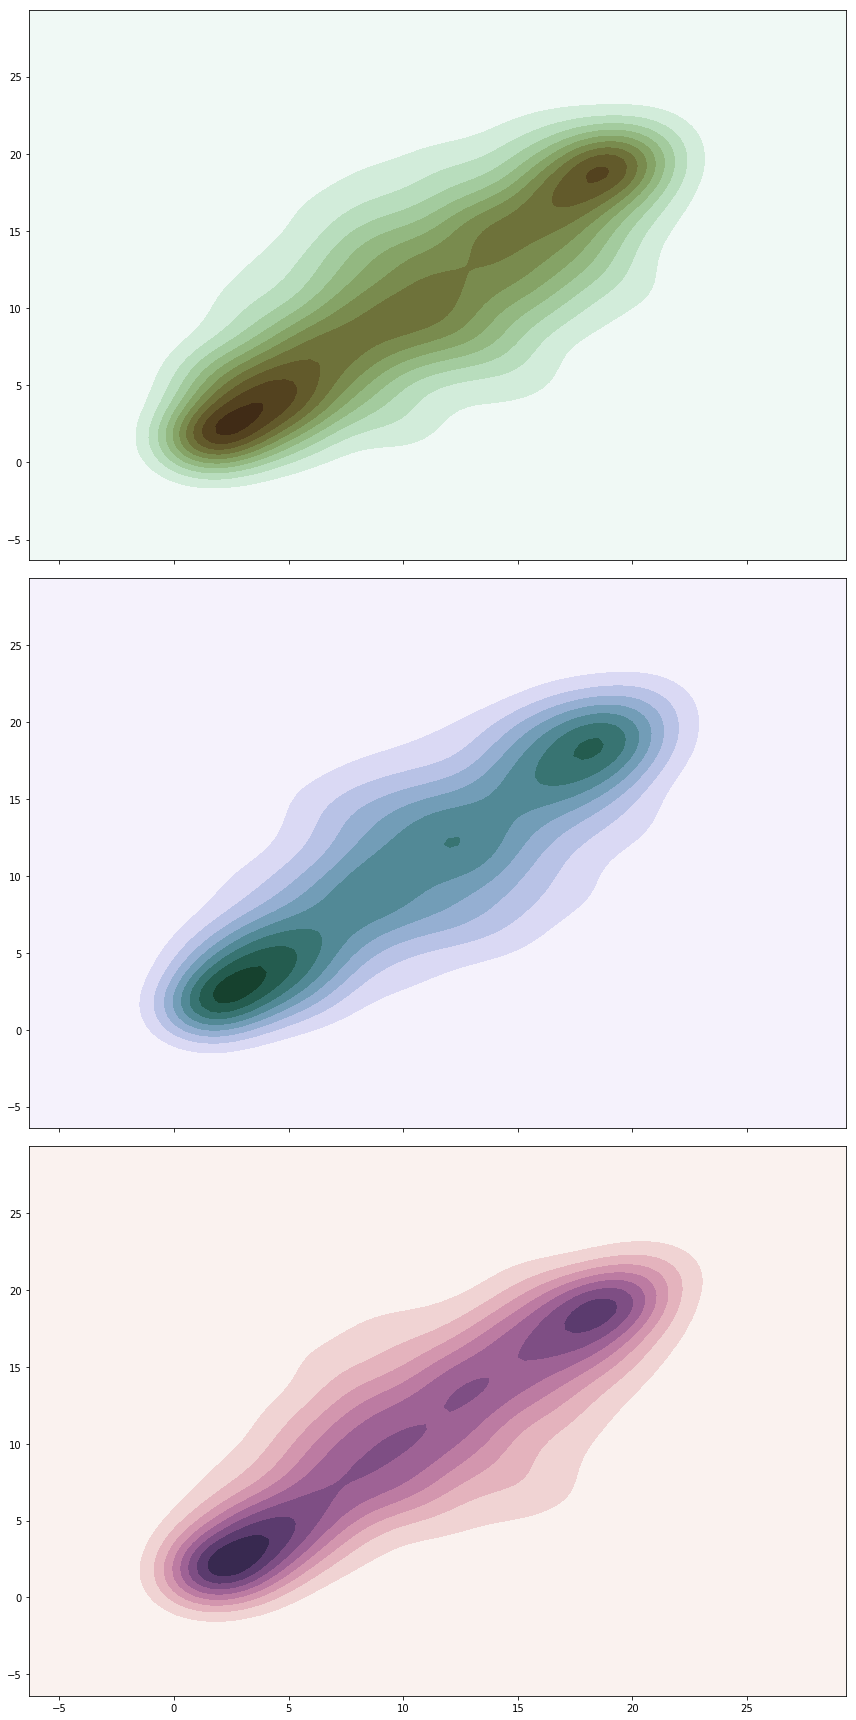

In [102]:
f, axes = plt.subplots(3, 1, figsize=(12, 24), sharex=True)

x = data['Q_pos'].values
y1 = data['P1_pos'].values
y2 = data['P2_pos'].values
y3 = data['P3_pos'].values

for ax, s, y in zip(axes.flat, np.linspace(1, 22, 23), [y1, y2, y3]):

    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    sns.kdeplot(x, y, cmap=cmap, shade=True, cut=5, ax=ax)

f.tight_layout()

In [103]:
features = ['q1_sec', 'q2_sec', 'q3_sec', 'leader_gap', 'front_gap', 'median_ahead', 'median_behind',
           'team_avg', 'team_last_3', 'team_last_5', 'last_3', 'last_5', 'P3_pos', 'P3_laps', 'P3_time', 
            'P3_leader_gap', 'P3_front_gap', 'P3_team_avg', 'P3_median_ahead', 'P3_median_behind', 'P2_pos', 
            'P2_laps', 'P2_time', 'P2_leader_gap', 'P2_front_gap', 'P2_team_avg', 'P2_median_ahead',
           'P2_median_behind', 'P1_pos', 'P1_laps', 'P1_time', 'P1_leader_gap', 'P1_front_gap', 'P1_team_avg', 
            'P1_median_ahead', 'P1_median_behind']

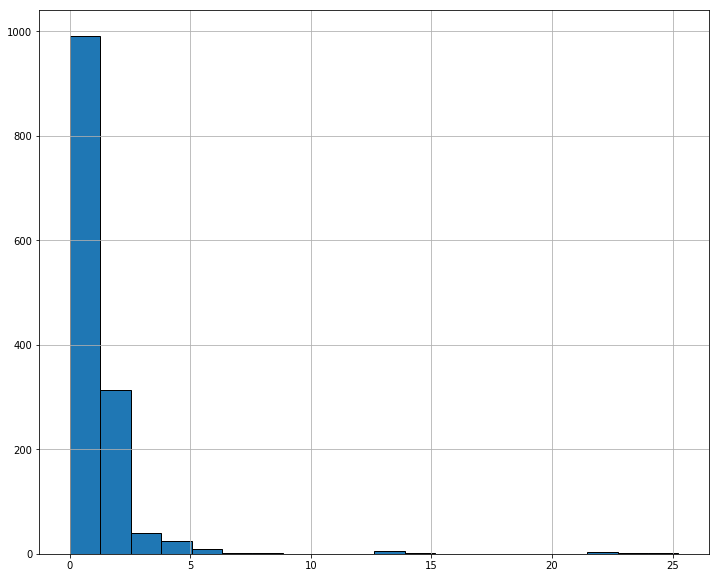

In [104]:
fig = plt.figure(figsize = (12, 10))

data['median_ahead'].hist(bins = 20, edgecolor = 'black')
plt.show()

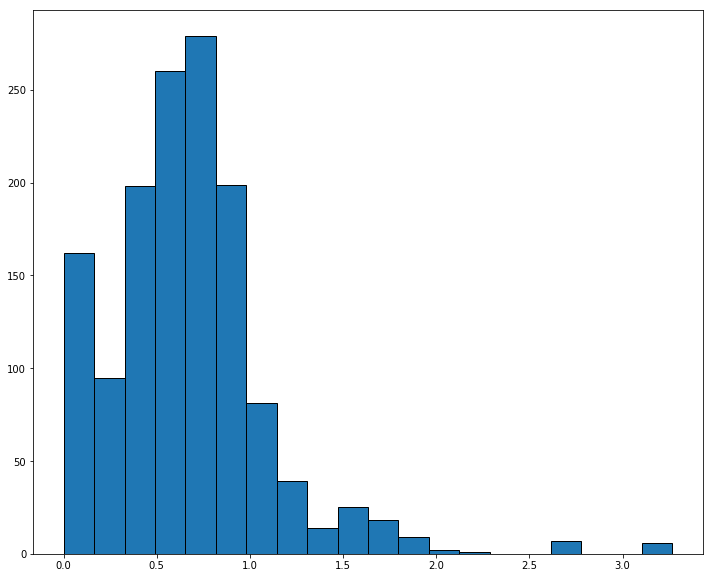

In [105]:
fig = plt.figure(figsize = (12, 10))

plt.hist(np.log(data['median_ahead'].values + 1), bins = 20, edgecolor = 'black')
plt.show()

In [106]:
# 11th race of 2016 season had rainy q1, so the results in q1 were really slow

data = data.drop(data[data['median_ahead'] > 12].index)

# Log for median_ahead could help

data.loc[:, 'median_ahead'] = np.log(data['median_ahead'].values + 1)

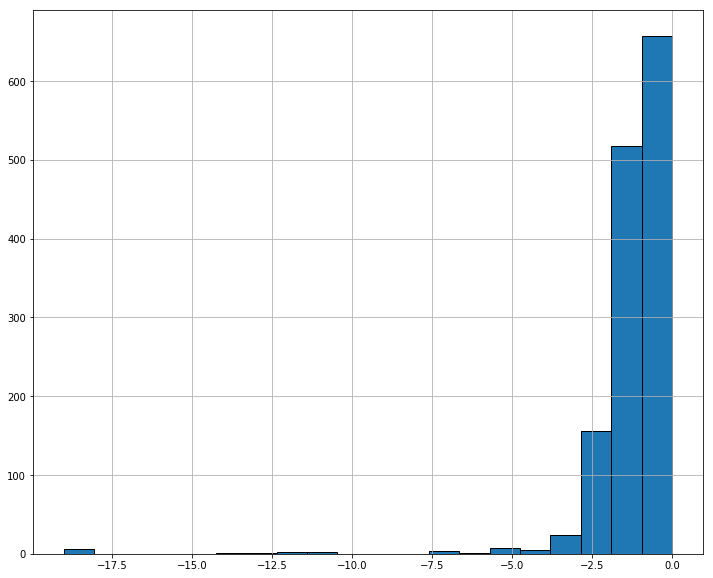

In [107]:
fig = plt.figure(figsize = (12, 10))

data['median_behind'].hist(bins = 20, edgecolor = 'black')
plt.show()

In [108]:
data[data['median_behind'] < -12.5][['driver', 'Q_pos', 'best_time', 'median_behind', 'race_no', 'season']]

,driver,Q_pos,best_time,median_behind,race_no,season
785,Kimi Räikkönen,14.0,85.435,-18.8360,11,2016
788,Valtteri Bottas,10.0,82.182,-13.3320,11,2016
790,Sergio Perez,13.0,85.416,-18.5830,11,2016
792,Esteban Gutierrez,15.0,86.189,-18.3540,11,2016
793,Romain Grosjean,11.0,84.941,-19.0240,11,2016
795,Daniil Kvyat,12.0,85.301,-18.6810,11,2016
796,Felipe Nasr,16.0,87.063,-18.7005,11,2016


In [109]:
data[(data['race_no'] == 11) & (data['season'] == 2016)][['driver', 'Q_pos', 'best_time', 'median_ahead', 'median_behind']]

,driver,Q_pos,best_time,median_ahead,median_behind
780,Lewis Hamilton,2.0,80.108,0.000894,-5.2505
781,Nico Rosberg,1.0,79.965,0.000000,-5.3360
782,Daniel Ricciardo,3.0,80.280,0.217930,-5.1360
783,Sebastian Vettel,5.0,80.874,0.518794,-4.5610
784,Max Verstappen,4.0,80.557,0.370874,-4.8685
785,Kimi Räikkönen,14.0,85.435,1.653263,-18.8360
786,Fernando Alonso,7.0,81.211,0.583611,-4.9780
787,Carlos Sainz,6.0,81.131,0.615726,-4.6810
788,Valtteri Bottas,10.0,82.182,0.836381,-13.3320
789,Nico Hulkenberg,9.0,81.823,0.745502,-5.2400


In [110]:
vals = np.log(data['front_gap'].values + 1)

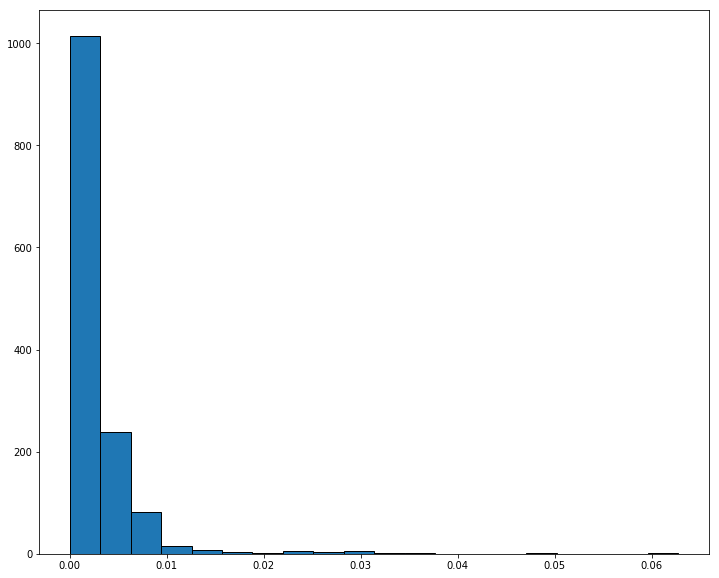

In [111]:
fig = plt.figure(figsize = (12, 10))

plt.hist(vals, bins = 20, edgecolor = 'black')

plt.show()

## Setting up algorithms

In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score

In [113]:
data.columns

Index(['pos', 'driver', 'team', 'laps', 'time', 'race_no', 'season', 'track',
       'engine', 'distance', 'Q_pos', 'q1', 'q2', 'q3', 'Q_laps', 'is_q2',
       'is_q3', 'q1_sec', 'q2_sec', 'q3_sec', 'best_time', 'leader_gap',
       'front_gap', 'best_time_order', 'median_ahead', 'median_behind',
       'team_avg', 'team_last_3', 'team_last_5', 'last_3', 'last_5', 'P3_pos',
       'P3_laps', 'P3_time', 'P3_leader_gap', 'P3_front_gap', 'P3_team_avg',
       'P3_median_ahead', 'P3_median_behind', 'P2_pos', 'P2_laps', 'P2_time',
       'P2_leader_gap', 'P2_front_gap', 'P2_team_avg', 'P2_median_ahead',
       'P2_median_behind', 'P1_pos', 'P1_laps', 'P1_time', 'P1_leader_gap',
       'P1_front_gap', 'P1_team_avg', 'P1_median_ahead', 'P1_median_behind'],
      dtype='object')

In [114]:
practice_cols = ['team_last_3', 'team_last_5', 'last_3', 'last_5', 'P3_pos',
       'P3_laps', 'P3_time', 'P3_leader_gap', 'P3_front_gap', 'P3_team_avg',
       'P3_median_ahead', 'P3_median_behind', 'P2_pos', 'P2_laps', 'P2_time',
       'P2_leader_gap', 'P2_front_gap', 'P2_team_avg', 'P2_median_ahead',
       'P2_median_behind', 'P1_pos', 'P1_laps', 'P1_time', 'P1_leader_gap',
       'P1_front_gap', 'P1_team_avg', 'P1_median_ahead', 'P1_median_behind']

quali_cols = ['Q_laps', 'is_q2', 'is_q3', 'q1_sec', 'q2_sec', 'q3_sec', 'best_time', 'leader_gap',
       'front_gap', 'best_time_order', 'median_ahead', 'median_behind', 'team_avg']

In [115]:
# Training and target sets for practice results

p_data = data[practice_cols].reset_index(drop = True)
p_target = data['Q_pos'].apply(lambda x: 1 if x < 11 else 0)

In [116]:
folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

In [117]:
# Specify a modeller based on LightGBM

def modeller_LGBM(X_full, y_full, n = 2000):

    scores = []
    valid_scores = []
    
    X, X_validation, y, y_validation = train_test_split(X_full, y_full, test_size = 0.2, stratify = y_full, shuffle = True, random_state = 4)
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        gc.collect()
        print('Fold', fold_n + 1)
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        d_train = lgb.Dataset(X_train, label=y_train)
        d_valid = lgb.Dataset(X_valid, label=y_valid)
        watchlist = [d_train, d_valid]
        
        early_stop = 500
        verbose_eval = False
        num_rounds = n
        n_splits = 5
        evals_result = {}
        
        params = {
            'application': 'regression', 
            'boosting': 'gbdt', 
            'metric': 'rmse', 
#             'num_leaves': 20, 
            'max_depth': 5, 
            'max_bin': 22, 
            'bagging_fraction': 0.5, 
#             'bagging_freq': 10, 
            'feature_fraction': 0.5, 
#             'min_split_gain': 0.5, 
            'min_child_samples': 6, 
#             'min_child_weight': 0.5, 
#             'lambda_l2': 0.5, 
            'learning_rate': 0.01,
            'verbosity': -1, 
            'data_random_seed': 17}
        
        model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      evals_result=evals_result,
                      early_stopping_rounds=early_stop)
        
        y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
        y_pred_validation = model.predict(X_validation, num_iteration=model.best_iteration)
        valid_scores.append(roc_auc_score(y_validation, y_pred_validation))

        scores.append(roc_auc_score(y_valid, y_pred_valid))
        print('Fold ROC-AUC:', scores[-1])
        print('Validation fold score:', valid_scores[-1])

    print('Fold mean test:', np.mean(scores))
    print('Valid mean test:', np.mean(valid_scores))
    
    return model

In [118]:
clf = modeller_LGBM(p_data, p_target)

Fold 1
Fold ROC-AUC: 0.9074030552291422
Validation fold score: 0.9402564904598061
Fold 2
Fold ROC-AUC: 0.9333725029377203
Validation fold score: 0.9351996663538735
Fold 3
Fold ROC-AUC: 0.9445236398194345
Validation fold score: 0.9427067042018559
Fold mean test: 0.9284330659954323
Valid mean test: 0.9393876203385118


In [119]:
p_data.columns

Index(['team_last_3', 'team_last_5', 'last_3', 'last_5', 'P3_pos', 'P3_laps',
       'P3_time', 'P3_leader_gap', 'P3_front_gap', 'P3_team_avg',
       'P3_median_ahead', 'P3_median_behind', 'P2_pos', 'P2_laps', 'P2_time',
       'P2_leader_gap', 'P2_front_gap', 'P2_team_avg', 'P2_median_ahead',
       'P2_median_behind', 'P1_pos', 'P1_laps', 'P1_time', 'P1_leader_gap',
       'P1_front_gap', 'P1_team_avg', 'P1_median_ahead', 'P1_median_behind'],
      dtype='object')

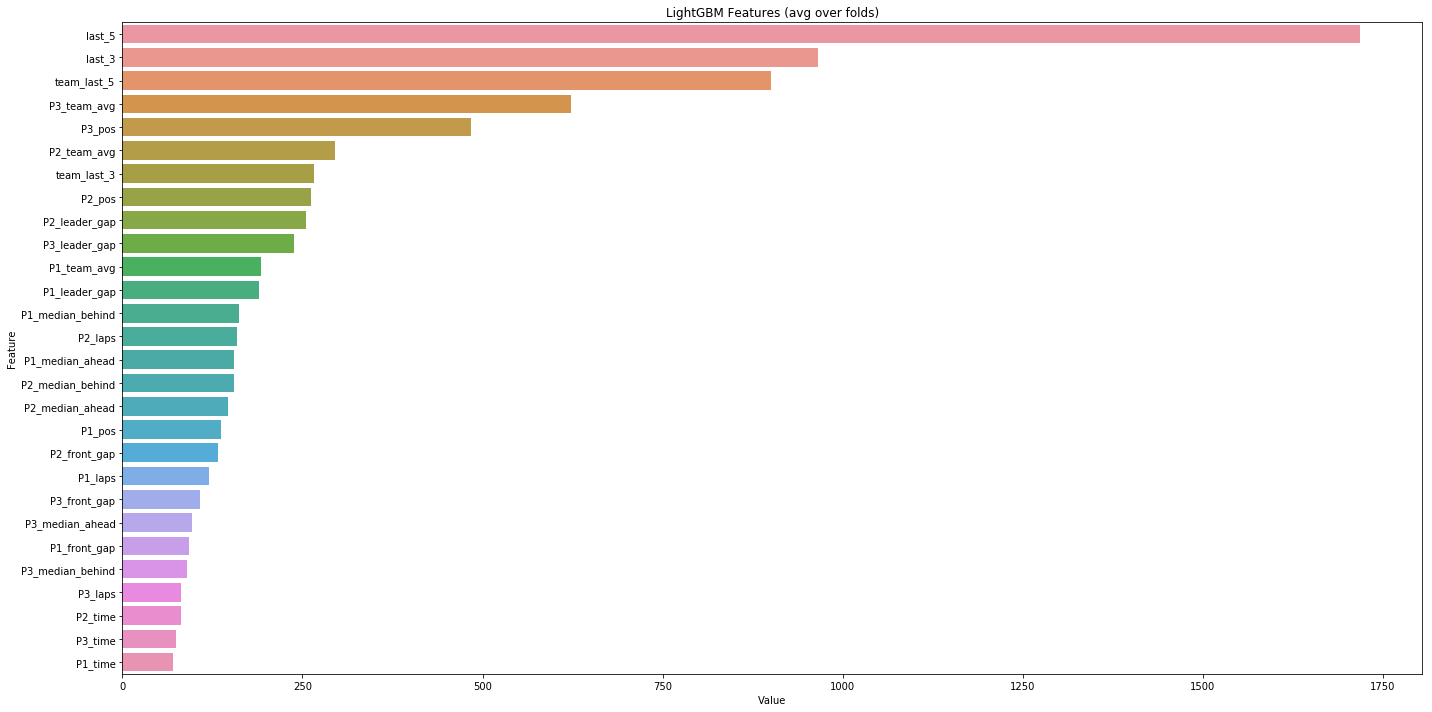

In [120]:
# Feature importance

feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(importance_type = 'gain'), p_data.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

## Calculating failure possibility

First we'll consider those who finished - non failed. Even though a leader could loose a lot of time due to some troubles and obviously fail the race

In [121]:
data.head(20)

,pos,driver,team,laps,time,race_no,season,track,engine,distance,...,P2_median_ahead,P2_median_behind,P1_pos,P1_laps,P1_time,P1_leader_gap,P1_front_gap,P1_team_avg,P1_median_ahead,P1_median_behind
0,1,Sebastian Vettel,Ferrari,57,1:24:11.672,1,2017,Albert Park,Ferrari,1.000000,...,0.003271,-1.6285,6.0,10.0,85.464,0.014771,0.001078,5.5,0.578000,-1.4610
1,2,Lewis Hamilton,Mercedes,57,+9.975s,1,2017,Albert Park,Mercedes,1.000000,...,0.000000,-1.9710,1.0,22.0,84.220,0.000000,0.000000,1.5,0.000000,-2.2300
2,3,Valtteri Bottas,Mercedes,57,+11.250s,1,2017,Albert Park,Mercedes,1.000000,...,0.282500,-1.8240,2.0,25.0,84.803,0.006922,0.006922,1.5,0.003461,-1.6790
3,4,Kimi Räikkönen,Ferrari,57,+22.393s,1,2017,Albert Park,Ferrari,1.000000,...,0.358000,-1.5475,5.0,16.0,85.372,0.013678,0.001478,5.5,0.527500,-1.3620
4,5,Max Verstappen,Red Bull,57,+28.827s,1,2017,Albert Park,Renault,1.000000,...,0.837000,-1.2250,4.0,19.0,85.246,0.012182,0.004241,3.5,0.443000,-1.3780
5,6,Felipe Massa,Williams,57,+83.386s,1,2017,Albert Park,Mercedes,1.000000,...,1.247000,-0.4325,7.0,28.0,86.142,0.022821,0.007933,10.0,1.076000,-0.9740
6,7,Sergio Perez,Force India,56,+1 lap,1,2017,Albert Park,Mercedes,1.000000,...,0.759500,-0.9340,10.0,29.0,86.276,0.024412,0.001079,13.0,0.904000,-1.2260
7,8,Carlos Sainz,Toro Rosso,56,+1 lap,1,2017,Albert Park,Renault,1.000000,...,0.733500,-1.2470,11.0,24.0,86.450,0.026478,0.002017,11.5,1.032000,-1.2060
8,9,Daniil Kvyat,Toro Rosso,56,+1 lap,1,2017,Albert Park,Renault,1.000000,...,0.843000,-1.0185,12.0,25.0,86.514,0.027238,0.000740,11.5,1.050000,-1.1475
9,10,Esteban Ocon,Force India,56,+1 lap,1,2017,Albert Park,Mercedes,1.000000,...,1.096500,-0.4630,16.0,23.0,87.656,0.040798,0.003526,13.0,1.488000,-0.9060


In [122]:
# Calculating driver fail rate

pilot_fails = {}
for driver in data['driver'].unique():
    pilot_fails[driver] = 1 - data[(data['driver'] == driver) & (data['distance'] < 1)]['pos'].count() / data[data['driver'] == driver]['pos'].count()

# Calculating track fail rate

track_fails = {}
for track in data['track'].unique():
    track_fails[track] = 1 - data[(data['track'] == track) & (data['distance'] < 1)]['pos'].count() / data[data['track'] == track]['pos'].count()

# Calculating car fail rate

car_fails = {}
for team in data['team'].unique():
    car_fails[team] = 1 - data[(data['team'] == team) & (data['distance'] < 1)]['pos'].count() / data[data['team'] == team]['pos'].count()

data['driver_fail'] = data['driver'].map(pilot_fails)
data['car_fail'] = data['team'].map(car_fails)
data['track_fail'] = data['track'].map(track_fails)

## Optimization

The basic idea here is that the chance of each driver to finish in top-10 depends on probability of drivers in top-10 to fail, which will result in some bonus to chance to "score" (finish in top-10). Obviously for the leader this bonus is 0, as nobody in front of him can fail, so he can't gain any positions due to that. For the second driver this chance is slightly better, as there is a chance that the leader will fail. And so on. For the 11th driver (as he is formally not considered to score) the bonus is quite big, as there is a huge chance, that at least one in top-10 will fail.

So this bonus "failure" chance is increasing from the leader to the back. But at some point it should begin to descrease again. As for the 20th driver at least 10 drivers in front should fail in order for him to score. And this is quite rare case.

So the idea is that before and after this border there should be quite different dependancies. And as we are not interested in the tail of the grid, we will try to find that border and train the model within it.

In [123]:
data['prediction'] = clf.predict(p_data)

In [124]:
opdata = data[['pos', 'prediction', 'driver_fail', 'car_fail', 'track_fail']].copy(deep = True)
optarget = opdata['pos'].apply(lambda x: 1 if x < 11 else 0)

In [125]:
def modeller_gbm(X_full, y_full, n = 2000):

    scores = []
    valid_scores = []
    
    X, X_validation, y, y_validation = train_test_split(X_full, y_full, test_size = 0.2, stratify = y_full, random_state = 4)
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        gc.collect()
        #print('Fold', fold_n + 1)
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        d_train = lgb.Dataset(X_train, label=y_train)
        d_valid = lgb.Dataset(X_valid, label=y_valid)
        watchlist = [d_train, d_valid]
        
        early_stop = 500
        verbose_eval = False
        num_rounds = n
        n_splits = 5
        evals_result = {}
        
        params = {
            'application': 'regression', 
            'boosting': 'gbdt', 
            'metric': 'rmse', 
#             'num_leaves': 20, 
            'max_depth': 5, 
            'max_bin': 22, 
            'bagging_fraction': 0.5, 
#             'bagging_freq': 10, 
            'feature_fraction': 0.5, 
#             'min_split_gain': 0.5, 
            'min_child_samples': 6, 
#             'min_child_weight': 0.5, 
#             'lambda_l2': 0.5, 
            'learning_rate': 0.01,
            'verbosity': -1, 
            'data_random_seed': 17}
        
        model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      evals_result=evals_result,
                      early_stopping_rounds=early_stop)
        
        y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
        y_pred_validation = model.predict(X_validation, num_iteration=model.best_iteration)
        valid_scores.append(roc_auc_score(y_validation, y_pred_validation))

        scores.append(roc_auc_score(y_valid, y_pred_valid))
        #print('Fold ROC-AUC:', scores[-1])
        #print('Validation fold score:', valid_scores[-1])

    print('Fold mean test:', np.mean(scores))
    print('Valid mean test:', np.mean(valid_scores))
    
    return model

In [126]:
full_data = data[practice_cols + quali_cols]
full_data['pos'] = data['pos']

D:\Soft\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [127]:
#full_data['distance'] = data['distance']
full_data['engine'] = data['engine']
full_data['Q_pos'] = data['Q_pos']

D:\Soft\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Soft\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [128]:
df_engine = pd.get_dummies(full_data['engine'])

In [129]:
full_data = pd.concat([full_data, df_engine], axis = 1)
full_data.shape

(1382, 48)

In [130]:
full_data = full_data.drop('engine', axis = 1)

In [131]:
full_data['driver_fail'] = data['driver_fail']
full_data['car_fail'] = data['car_fail']
full_data['track_fail'] = data['track_fail']
full_data['driver'] = data['driver']

In [132]:
final_data = full_data[full_data['pos'] <= 16]
final_target = full_data[full_data['pos'] <= 16]['pos'].apply(lambda x: 1 if x < 11 else 0)
final_data.reset_index(drop = True, inplace = True)

final_train = final_data.iloc[:1050]
final_test = final_data.iloc[1050:]
final_train_label = final_data.iloc[:1050]['pos'].apply(lambda x: 1 if x < 11 else 0)
final_test_label = final_data.iloc[1050:]['pos'].apply(lambda x: 1 if x < 11 else 0)
test_positions = final_data.iloc[1050:]['pos']

final_data = final_data.drop('pos', axis = 1)
final_train = final_train.drop('pos', axis = 1)
final_test = final_test.drop('pos', axis = 1)

In [133]:
final_test.columns

Index(['team_last_3', 'team_last_5', 'last_3', 'last_5', 'P3_pos', 'P3_laps',
       'P3_time', 'P3_leader_gap', 'P3_front_gap', 'P3_team_avg',
       'P3_median_ahead', 'P3_median_behind', 'P2_pos', 'P2_laps', 'P2_time',
       'P2_leader_gap', 'P2_front_gap', 'P2_team_avg', 'P2_median_ahead',
       'P2_median_behind', 'P1_pos', 'P1_laps', 'P1_time', 'P1_leader_gap',
       'P1_front_gap', 'P1_team_avg', 'P1_median_ahead', 'P1_median_behind',
       'Q_laps', 'is_q2', 'is_q3', 'q1_sec', 'q2_sec', 'q3_sec', 'best_time',
       'leader_gap', 'front_gap', 'best_time_order', 'median_ahead',
       'median_behind', 'team_avg', 'Q_pos', 'Ferrari', 'Honda', 'Mercedes',
       'Renault', 'driver_fail', 'car_fail', 'track_fail', 'driver'],
      dtype='object')

In [134]:
# With fails

clf_lgbm_full = modeller_gbm(final_train.drop('driver', axis = 1), final_train_label)

Fold mean test: 0.8772602641904931
Valid mean test: 0.8826611984506721


In [135]:
preds = clf_lgbm_full.predict(final_test.drop('driver', axis = 1), num_iteration=clf_lgbm_full.best_iteration)

In [136]:
#data = data.drop('final', axis = 1)
final_test['final'] = preds
final_test['pos'] = test_positions

In [137]:
# Results with qualification

final_test[['pos', 'P1_pos', 'P2_pos', 'P3_pos', 'Q_pos', 'best_time_order', 'driver', 'driver_fail', 'car_fail', 'track_fail', 'final']]

,pos,P1_pos,P2_pos,P3_pos,Q_pos,best_time_order,driver,driver_fail,car_fail,track_fail,final
1050,1,2.0,1.0,1.0,1.0,1.0,Nico Rosberg,0.925000,0.926471,0.870968,0.955534
1051,2,1.0,2.0,2.0,2.0,2.0,Lewis Hamilton,0.940299,0.926471,0.870968,0.931891
1052,3,3.0,7.0,5.0,3.0,3.0,Kimi Räikkönen,0.782609,0.839416,0.870968,0.928070
1053,4,5.0,5.0,3.0,16.0,16.0,Sebastian Vettel,0.897059,0.839416,0.870968,0.874514
1054,5,8.0,3.0,4.0,4.0,4.0,Sergio Perez,0.927536,0.862319,0.870968,0.909587
1055,6,7.0,4.0,6.0,5.0,5.0,Daniel Ricciardo,0.808824,0.816176,0.870968,0.856218
1056,7,6.0,8.0,7.0,7.0,7.0,Nico Hulkenberg,0.710145,0.862319,0.870968,0.916116
1057,8,10.0,12.0,8.0,8.0,8.0,Felipe Massa,0.862069,0.843284,0.870968,0.822466
1058,9,15.0,15.0,15.0,15.0,13.0,Romain Grosjean,0.761194,0.578947,0.870968,0.276584
1059,10,4.0,6.0,20.0,9.0,9.0,Daniil Kvyat,0.781818,0.816176,0.870968,0.812014


In [138]:
# Testing only practice results

full_data = data[practice_cols]
full_data['pos'] = data['pos']
full_data['engine'] = data['engine']
df_engine = pd.get_dummies(full_data['engine'])
full_data = pd.concat([full_data, df_engine], axis = 1)
full_data = full_data.drop('engine', axis = 1)
full_data['driver_fail'] = data['driver_fail']
full_data['car_fail'] = data['car_fail']
full_data['track_fail'] = data['track_fail']
full_data['driver'] = data['driver']
final_data = full_data[full_data['pos'] <= 16]
final_target = full_data[full_data['pos'] <= 16]['pos'].apply(lambda x: 1 if x < 11 else 0)
final_data.reset_index(drop = True, inplace = True)

final_train = final_data.iloc[:1050]
final_test = final_data.iloc[1050:]
final_train_label = final_data.iloc[:1050]['pos'].apply(lambda x: 1 if x < 11 else 0)
final_test_label = final_data.iloc[1050:]['pos'].apply(lambda x: 1 if x < 11 else 0)
test_positions = final_data.iloc[1050:]['pos']

final_data = final_data.drop('pos', axis = 1)
final_train = final_train.drop('pos', axis = 1)
final_test = final_test.drop('pos', axis = 1)

clf_lgbm_full = modeller_gbm(final_train.drop('driver', axis = 1), final_train_label)

preds = clf_lgbm_full.predict(final_test.drop('driver', axis = 1), num_iteration=clf_lgbm_full.best_iteration)

final_test['final'] = preds
final_test['pos'] = test_positions

D:\Soft\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
D:\Soft\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Fold mean test: 0.8679956135320624
Valid mean test: 0.8806757152621815


In [139]:
final_test[['pos', 'P1_pos', 'P2_pos', 'P3_pos', 'driver', 'driver_fail', 'car_fail', 'track_fail', 'final']]

,pos,P1_pos,P2_pos,P3_pos,driver,driver_fail,car_fail,track_fail,final
1050,1,2.0,1.0,1.0,Nico Rosberg,0.925000,0.926471,0.870968,0.969855
1051,2,1.0,2.0,2.0,Lewis Hamilton,0.940299,0.926471,0.870968,0.969633
1052,3,3.0,7.0,5.0,Kimi Räikkönen,0.782609,0.839416,0.870968,0.973369
1053,4,5.0,5.0,3.0,Sebastian Vettel,0.897059,0.839416,0.870968,0.970720
1054,5,8.0,3.0,4.0,Sergio Perez,0.927536,0.862319,0.870968,0.937225
1055,6,7.0,4.0,6.0,Daniel Ricciardo,0.808824,0.816176,0.870968,0.862984
1056,7,6.0,8.0,7.0,Nico Hulkenberg,0.710145,0.862319,0.870968,0.883206
1057,8,10.0,12.0,8.0,Felipe Massa,0.862069,0.843284,0.870968,0.916706
1058,9,15.0,15.0,15.0,Romain Grosjean,0.761194,0.578947,0.870968,0.237986
1059,10,4.0,6.0,20.0,Daniil Kvyat,0.781818,0.816176,0.870968,0.791453


Looks like results only on practice data doesn't differ much from the qualification + practice data. Usually if you make stake before qualification, the coefficients are better, so we will leave only practice data

Works fine. Let's play with failure conditions. Consider failed those, who lost more than 1 lap to leader

In [140]:
# Calculating distance passed before withdrawal
# Those finished the race in several laps behind the winner are considered passed 100% distance

data['new_distance'] = 0
races = [x for x in range(1, 22)]
seasons = [2015, 2016, 2017, 2018]

for s in seasons:
    for r in races:
        data.loc[(data['season'] == s) & (data['race_no'] == r) & (data['time'] != 'DNF'), 'new_distance'] = 1
        overall_laps = data.loc[(data['season'] == s) & (data['race_no'] == r) & (data['pos'] == 1), 'laps'].values
        if len(overall_laps) == 0:
            continue
        laps = data.loc[(data['season'] == s) & (data['race_no'] == r) & (data['laps'] < (overall_laps[0] - 1)), 'laps'].values
        data.loc[(data['season'] == s) & (data['race_no'] == r) & (data['laps'] < (overall_laps[0] - 1)), 'new_distance'] = laps / overall_laps

In [141]:
# Calculating driver fail rate

pilot_fails = {}
for driver in data['driver'].unique():
    pilot_fails[driver] = 1 - data[(data['driver'] == driver) & (data['distance'] < 1)]['pos'].count() / data[data['driver'] == driver]['pos'].count()

# Calculating track fail rate

track_fails = {}
for track in data['track'].unique():
    track_fails[track] = 1 - data[(data['track'] == track) & (data['distance'] < 1)]['pos'].count() / data[data['track'] == track]['pos'].count()

# Calculating car fail rate

car_fails = {}
for team in data['team'].unique():
    car_fails[team] = 1 - data[(data['team'] == team) & (data['distance'] < 1)]['pos'].count() / data[data['team'] == team]['pos'].count()

data['driver_fail'] = data['driver'].map(pilot_fails)
data['car_fail'] = data['team'].map(car_fails)
data['track_fail'] = data['track'].map(track_fails)

In [144]:
# Testing harder distance rules

full_data = data[practice_cols]
full_data['pos'] = data['pos']
full_data['engine'] = data['engine']
df_engine = pd.get_dummies(full_data['engine'])
full_data = pd.concat([full_data, df_engine], axis = 1)
full_data = full_data.drop('engine', axis = 1)
full_data['driver_fail'] = data['driver_fail']
full_data['car_fail'] = data['car_fail']
full_data['track_fail'] = data['track_fail']
full_data['driver'] = data['driver']
final_data = full_data[full_data['pos'] <= 16]
final_target = full_data[full_data['pos'] <= 16]['pos'].apply(lambda x: 1 if x < 11 else 0)
final_data.reset_index(drop = True, inplace = True)

final_train = final_data.iloc[:1050]
final_test = final_data.iloc[1050:]
final_train_label = final_data.iloc[:1050]['pos'].apply(lambda x: 1 if x < 11 else 0)
final_test_label = final_data.iloc[1050:]['pos'].apply(lambda x: 1 if x < 11 else 0)
test_positions = final_data.iloc[1050:]['pos']

final_data = final_data.drop('pos', axis = 1)
final_train = final_train.drop('pos', axis = 1)
final_test = final_test.drop('pos', axis = 1)

clf_lgbm_full = modeller_gbm(final_train.drop('driver', axis = 1), final_train_label)

preds = clf_lgbm_full.predict(final_test.drop('driver', axis = 1), num_iteration=clf_lgbm_full.best_iteration)

final_test['final'] = preds
final_test['pos'] = test_positions

D:\Soft\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
D:\Soft\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Fold mean test: 0.8679956135320624
Valid mean test: 0.8806757152621815


In [145]:
final_test[['pos', 'P1_pos', 'P2_pos', 'P3_pos', 'driver', 'driver_fail', 'car_fail', 'track_fail', 'final']]

,pos,P1_pos,P2_pos,P3_pos,driver,driver_fail,car_fail,track_fail,final
1050,1,2.0,1.0,1.0,Nico Rosberg,0.925000,0.926471,0.870968,0.969855
1051,2,1.0,2.0,2.0,Lewis Hamilton,0.940299,0.926471,0.870968,0.969633
1052,3,3.0,7.0,5.0,Kimi Räikkönen,0.782609,0.839416,0.870968,0.973369
1053,4,5.0,5.0,3.0,Sebastian Vettel,0.897059,0.839416,0.870968,0.970720
1054,5,8.0,3.0,4.0,Sergio Perez,0.927536,0.862319,0.870968,0.937225
1055,6,7.0,4.0,6.0,Daniel Ricciardo,0.808824,0.816176,0.870968,0.862984
1056,7,6.0,8.0,7.0,Nico Hulkenberg,0.710145,0.862319,0.870968,0.883206
1057,8,10.0,12.0,8.0,Felipe Massa,0.862069,0.843284,0.870968,0.916706
1058,9,15.0,15.0,15.0,Romain Grosjean,0.761194,0.578947,0.870968,0.237986
1059,10,4.0,6.0,20.0,Daniil Kvyat,0.781818,0.816176,0.870968,0.791453


The results are the same. So there is not too much failure border calculation method influence

## Algorithm setup

In [156]:
def modeller_gbm(X_full, y_full, mode = 'regression', n = 280, depth = 6, 
                 child = 2, bag = 0.95, feature = 0.3, l1 = 0.001, l = 0.0009):

    scores = []
    valid_scores = []
    
    X, X_validation, y, y_validation = train_test_split(X_full, y_full, test_size = 0.2, 
                                                        stratify = y_full, random_state = 4)
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        gc.collect()
        #print('Fold', fold_n + 1)
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        d_train = lgb.Dataset(X_train, label=y_train)
        d_valid = lgb.Dataset(X_valid, label=y_valid)
        watchlist = [d_train, d_valid]
        
        early_stop = 500
        verbose_eval = False
        num_rounds = n
        n_splits = 5
        evals_result = {}
        
        params = {
            'application': mode,
            'objective': 'binary',
            'boosting': 'gbdt', 
            'metric': 'binary-logloss',
            'is_unbalance': 'True',
#             'num_leaves': 20, 
            'max_depth': depth, 
            'max_bin': 22, 
            'bagging_fraction': bag, 
#             'bagging_freq': 10, 
            'feature_fraction': feature, 
#             'min_split_gain': 0.5, 
            'min_child_samples': child, 
            'min_child_weight': 1, 
#             'lambda_l2': 0.5, 
            'learning_rate': l,
            'verbosity': -1, 
            'data_random_seed': 17,
            'lambda_l1': l1}
        
        model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      evals_result=evals_result)#,
                      #early_stopping_rounds=early_stop)
        
        y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
        y_pred_validation = model.predict(X_validation, num_iteration=model.best_iteration)
        valid_scores.append(roc_auc_score(y_validation, y_pred_validation))

        scores.append(roc_auc_score(y_valid, y_pred_valid))
        #print('Fold ROC-AUC:', scores[-1])
        #print('Validation fold score:', valid_scores[-1])

    #print('Fold mean test:', np.mean(scores))
    #print('Valid mean test:', np.mean(valid_scores))
    
    return model, np.mean(valid_scores)


In [147]:
x_train, x_test, y_train, y_test = train_test_split(final_data, final_target, test_size = 0.2, stratify = final_target)

First check objectives

In [148]:
modes = ['regression', 'regression_l1', 'huber', 'fair', 'poisson', 'quantile', 'mape', 'gamma', 'tweedie', 'binary', 'xentropy', 'xentlambda']
scores = []
for mode in modes:
    clf, score = modeller_gbm(x_train.drop('driver', axis = 1), y_train, mode = mode)
    scores.append([score, mode])
scores

[[0.8538799694189603, 'regression'],
 [0.8538799694189603, 'regression_l1'],
 [0.8538799694189603, 'huber'],
 [0.8538799694189603, 'fair'],
 [0.8538799694189603, 'poisson'],
 [0.8538799694189603, 'quantile'],
 [0.8538799694189603, 'mape'],
 [0.8538799694189603, 'gamma'],
 [0.8538799694189603, 'tweedie'],
 [0.8538799694189603, 'binary'],
 [0.8538799694189603, 'xentropy'],
 [0.8538799694189603, 'xentlambda']]

Picking basic pair on n_estimators and learing rate. Consider learning rate = 0.001, pick the optimal n_estimators

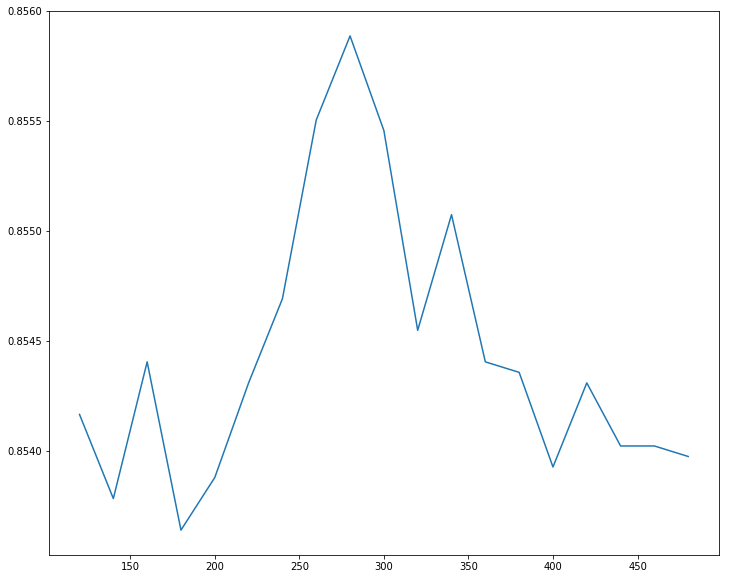

In [150]:
ns = [x for x in range(120, 500, 20)]
scores = []
for n in ns:
    clf, score = modeller_gbm(x_train.drop('driver', axis = 1), y_train, n = n)
    scores.append(score)

fig = plt.figure(figsize = (12, 10))
plt.plot(ns, scores)
plt.show()

It is 140 then
Now let's search for max_depth and min_child_weight

In [155]:
depths = [x for x in range(2, 15)]
child_weight = [x for x in range(1, 10)]
scores = []
for depth in depths:
    for child in child_weight:
        clf, score = modeller_gbm(x_train.drop('driver', axis = 1), y_train, depth = depth, child = child)
        scores.append([score, child, depth])
max(scores)

[0.8627914755351682, 6, 2]

Max depth is 5, min_child_weight is 1

Now check bagging and feature fractions

In [158]:
bags = [x / 100 for x in range(10, 101, 5)]
feats = [x / 100 for x in range(10, 101, 5)]
scores = []
for bag in bags:
    for feature in feats:
        clf, score = modeller_gbm(x_train.drop('driver', axis = 1), y_train, bag = bag, feature = feature)
        scores.append([score, bag, feature])
max(scores)

[0.8609518348623854, 1.0, 0.1]

Pretty low level for feature subsample, but still it's locally the best

Now check regularization

In [159]:
lambda_l1 = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4]
for l1 in lambda_l1:
    clf, score = modeller_gbm(x_train.drop('driver', axis = 1), y_train, l1 = l1)
    print(l1, score)

1e-06 0.8539755351681958
1e-05 0.8540711009174312
0.0001 0.8540711009174311
0.001 0.8542622324159023
0.01 0.8538321865443425
0.1 0.8531154434250765
1 0.8573203363914373
100.0 0.8383744266055047
1000.0 0.5
10000.0 0.5


Best regularizer is 0.001

Finally drop down learning rate

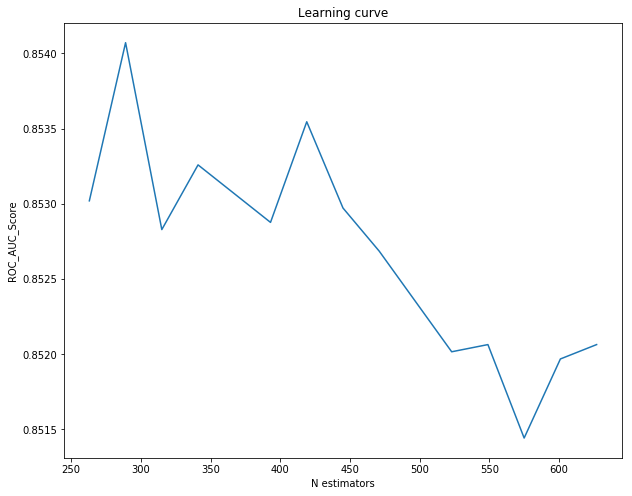

In [160]:
learnings = [0.001 / (1 + x / 100) for x in range(1, 150, 10)]
ns = list(map(round, [260 * (1 + x / 100) for x in range(1, 150, 10)]))
scores = []
for n, l in zip(ns, learnings):
    clf, score = modeller_gbm(x_train.drop('driver', axis = 1), y_train, l = l, n = n)
    scores.append(score)
fig = plt.figure(figsize = (10, 8))
plt.plot(ns, scores, antialiased = True)
plt.title("Learning curve")
plt.xlabel("N estimators")
plt.ylabel("ROC_AUC_Score")
plt.show()

Optimal number of trees is 200 while learning rate is 0.0009

In [162]:
# Final score

clf, score = modeller_gbm(x_train.drop('driver', axis = 1), y_train)
score

0.8542622324159023

In [63]:
x_train.columns

Index(['team_last_3', 'team_last_5', 'last_3', 'last_5', 'P3_pos', 'P3_laps',
       'P3_time', 'P3_leader_gap', 'P3_front_gap', 'P3_team_avg',
       'P3_median_ahead', 'P3_median_behind', 'P2_pos', 'P2_laps', 'P2_time',
       'P2_leader_gap', 'P2_front_gap', 'P2_team_avg', 'P2_median_ahead',
       'P2_median_behind', 'P1_pos', 'P1_laps', 'P1_time', 'P1_leader_gap',
       'P1_front_gap', 'P1_team_avg', 'P1_median_ahead', 'P1_median_behind',
       'Ferrari', 'Honda', 'Mercedes', 'Renault', 'driver_fail', 'car_fail',
       'track_fail', 'driver'],
      dtype='object')

## Building prediction

In [164]:
prac = pd.read_csv('Practice_to_predict.csv', names = ['pos', 'no', 'driver', 'team', 'time', 'gap', 'laps', 'session', 'race_no', 'season', 'track'],
                  skiprows = [0])
prac.drop('no', axis = 1, inplace = True)
prac.head()

,pos,driver,team,time,gap,laps,session,race_no,season,track
0,1,Sebastian Vettel,FERRARI,01:33.9,NaN,19,P1,3,2019,Shanghai International Circuit
1,2,Lewis Hamilton,MERCEDES,01:34.1,+0.207s,21,P1,3,2019,Shanghai International Circuit
2,3,Charles Leclerc,FERRARI,01:34.2,+0.256s,21,P1,3,2019,Shanghai International Circuit
3,4,Max Verstappen,RED BULL RACING HONDA,01:34.3,+0.423s,20,P1,3,2019,Shanghai International Circuit
4,5,Valtteri Bottas,MERCEDES,01:34.7,+0.742s,23,P1,3,2019,Shanghai International Circuit


In [165]:
prac.loc[prac['time'].isna(), 'time'] = '10:00.000'

# Calculating all practice times in seconds

prac.loc[(prac['time'].str.contains('|'.join(['DNF', 'DNS'])) | (prac['time'] == '0')), 'time'] = '10:00.000'
pr_res = [datetime.strptime(x, '%M:%S.%f') for x in prac['time'].values]
pr_sec = [a.minute * 60 + a.second + a.microsecond / 1000000 for a in pr_res]
prac['time_sec'] = pr_sec

In [166]:
# Extracting separately info for P1, P2 and P3. Adding time in seconds and session position

pr1 = prac[prac['session'] == 'P1']
pr2 = prac[prac['session'] == 'P2']
pr3 = prac[prac['session'] == 'P3']

In [167]:
# Session leader gap share

races = prac['race_no'].unique()
seasons = prac['season'].unique()

sessions = [pr1, pr2, pr3]
for df in sessions:
    df.loc[:, 'leader_gap'] = 0
    for s in seasons:
        for r in races:
            leader = df[(df['pos'] == 1) & (df['race_no'] == r) & (df['season'] == s)]['time_sec'].values
            gaps = [(x - leader) / leader for x in df[(df['race_no'] == r) & 
                                                        (df['season'] == s)]['time_sec'].values]
            df.loc[(df['race_no'] == r) & (df['season'] == s), 'leader_gap'] = gaps
            
# Front car gap share

for df in sessions:
    
    df.loc[:, 'front_gap'] = 0

    for s in seasons:
        for r in races:          
            time_front = df[(df['race_no'] == r) & (df['season'] == s)]['time_sec'].values
            gaps = [0]
            for i in range(1, len(time_front)):
                gaps.append((time_front[i] - time_front[i - 1]) / time_front[i - 1])

            df.loc[(df['race_no'] == r) & (df['season'] == s), 'front_gap'] = gaps

# Team mean session position

for df in sessions:
    
    df.loc[:, 'team_avg'] = 0

    for s in seasons:
        for r in races:
            race_df = df.loc[(df['race_no'] == r) & (df['season'] == s), ['team', 'pos']]

            if race_df.shape[0] > 0:

                race_df.loc[:, 'team_avg'] = 0
                for team in race_df['team'].unique():
                    race_df.loc[race_df['team'] == team, 
                                'team_avg'] = race_df[race_df['team'] == team]['pos'].mean()
                team = race_df['team_avg'].values
                df.loc[(df['race_no'] == r) & (df['season'] == s), 'team_avg'] = team
                
# Best time median ahead and behind gap

for df in sessions:
    
    df.loc[:, 'median_ahead'] = 0
    df.loc[:, 'median_behind'] = 0

    for s in seasons:
        for r in races:
            race_df = df.loc[(df['race_no'] == r) & (df['season'] == s), 
                               ['time_sec', 'front_gap', 'pos']]

            if race_df.shape[0] > 0:

                # Medians ahead

                medians_ahead = [0, race_df.iloc[1]['front_gap'] / 2]
                for i in range(2, race_df.shape[0]):
                    times = race_df.iloc[:i]['time_sec'].values
                    medians_ahead.append(race_df.iloc[i]['time_sec'] - np.median(times))

                #  Medians behind

                medians_behind = []

                for i in range(race_df.shape[0] - 2):
                    times = race_df.iloc[i + 1:]['time_sec'].values
                    medians_behind.append(race_df.iloc[i]['time_sec'] - np.median(times))

                medians_behind.append((race_df.iloc[race_df.shape[0] - 2]
                                       ['time_sec'] - race_df.iloc[race_df.shape[0] - 1]['time_sec']) / 2)
                medians_behind.append(0)

                df.loc[(df['race_no'] == r) & (df['season'] == s), 'median_ahead'] = medians_ahead
                df.loc[(df['race_no'] == r) & (df['season'] == s), 'median_behind'] = medians_behind

D:\Soft\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\Soft\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [ ]:
# Adding features for 2nd and 3rd quali segments if driver made through

qual['is_q2'] = 0
qual['is_q3'] = 0
qual.loc[~qual['q2'].isna(), 'is_q2'] = 1
qual.loc[~qual['q3'].isna(), 'is_q3'] = 1

In [ ]:
# Calculating quali best time for driver

races = [x for x in range(1, 22)]
seasons = [2015, 2016, 2017, 2018]

qual.loc[qual['q1'].isna(), 'q1'] = '10:00.000'
qual.drop(qual[qual['q1'] == '10:00.000'].index, inplace = True)
qual.loc[qual['q2'].isna(), 'q2'] = '10:00.000'
qual.loc[qual['q3'].isna(), 'q3'] = '10:00.000'

# Calculating all quali times in seconds
quali_times = []
for q_segment in ['q1', 'q2', 'q3']:
    qual.loc[qual[q_segment].str.contains('|'.join(['DNF', 'DNS'])), q_segment] = '10:00.000'
    q_res = [datetime.strptime(x, '%M:%S.%f') for x in qual[q_segment].values]
    q_sec = [a.minute * 60 + a.second + a.microsecond / 1000000 for a in q_res]
    new_seg = q_segment + '_sec'
    quali_times.append(q_sec)
    qual[new_seg] = q_sec
    
# Choosing the fastest time for a drive in all segments
times_per_driver = [min(a, b, c) for a, b, c in zip(quali_times[0], quali_times[1], quali_times[2])]
qual['best_time'] = times_per_driver

for s in seasons:
    for r in races:
        if len(qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'best_time']) > 0:
            qual.loc[(qual['race_no'] == r) & (qual['season'] == s) & (qual['q1'] == '10:00.000'), 
                     'best_time'] = max(qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'best_time']) * 1.01
            qual.drop(qual[qual['q1'] == '10:00.000'].index, inplace = True)

In [ ]:
# Best time leader gap (share, here and below)

# !!! CLEAN THE MEMORY AFTER ARRANGING TO FUNCTIONS

races = [x for x in range(1, 22)]
seasons = [2015, 2016, 2017, 2018]

qual['leader_gap'] = 0
for s in seasons:
    for r in races:
        leader = qual[(qual['pos'] == 1) & (qual['race_no'] == r) & (qual['season'] == s)]['best_time'].values
        gaps = [(x - leader) / leader for x in qual[(qual['race_no'] == r) & 
                                                    (qual['season'] == s)]['best_time'].values]
        qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'leader_gap'] = gaps

# Best time front gap

# !! TRY TO CHECK GAP BEHIND

qual['front_gap'] = 0
qual['best_time_order'] = 0
for s in seasons:
    for r in races:
        real_order = pd.DataFrame({'best_time': qual[(qual['race_no'] == r) & 
                                                     (qual['season'] == s)]['best_time'].values, 
                                   'pos': qual[(qual['race_no'] == r) & (qual['season'] == s)]['pos'].values})
        real_order = real_order.sort_values(by = 'best_time').reset_index(drop = True)
        real_order['best_time_pos'] = [x + 1 for x in real_order.index.tolist()]
        
        time_front = real_order['best_time'].values
        gaps = [0]
        for i in range(1, real_order.shape[0]):
            gaps.append((time_front[i] - time_front[i - 1]) / time_front[i - 1])
        real_order['front_gap'] = gaps
        
        old_order = real_order.sort_values(by = 'pos').reset_index()
        front_gaps = old_order['front_gap'].values
        best_time_order = [x + 1 for x in old_order['index'].values]
        
        qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'front_gap'] = front_gaps
        qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'best_time_order'] = best_time_order

# Best time median ahead and behind gap

qual['median_ahead'] = 0
qual['median_behind'] = 0
for s in seasons:
    for r in races:
        race_df = qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 
                           ['best_time', 'best_time_order', 'front_gap', 'pos']]
        race_df = race_df.sort_values(by = ['best_time']).reset_index(drop = True)
        
        if race_df.shape[0] > 0:
        
            # Medians ahead

            medians = [0, race_df.iloc[1]['front_gap'] / 2]
            for i in range(2, race_df.shape[0]):
                times = race_df.iloc[:i]['best_time'].values
                medians.append(race_df.iloc[i]['best_time'] - np.median(times))

            race_df['medians_ahead'] = medians    

            #  Medians behind

            medians = []

            for i in range(race_df.shape[0] - 2):
                times = race_df.iloc[i + 1:]['best_time'].values
                medians.append(race_df.iloc[i]['best_time'] - np.median(times))

            medians.append((race_df.iloc[race_df.shape[0] - 2]['best_time'] - race_df.iloc[race_df.shape[0] - 1]
                            ['best_time']) / 2)
            medians.append(0)

            race_df['medians_behind'] = medians

            old_order = race_df.sort_values(by = 'pos').reset_index(drop = True)
            median_ahead = old_order['medians_ahead'].values
            median_behind = old_order['medians_behind'].values
            qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'median_ahead'] = median_ahead
            qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'median_behind'] = median_behind

In [ ]:
# Now we need to add mean team result, mean result for the last 3 and 5 races (driver and team)

# First mean team result in current race

qual['team_avg'] = 0
for s in seasons:
    for r in races:
        race_df = qual.loc[(qual['race_no'] == r) & (qual['season'] == s), ['team', 'best_time_order']]
        
        if race_df.shape[0] > 0:
            
            race_df['team_avg'] = 0
            for team in race_df['team'].unique():
                race_df.loc[race_df['team'] == team, 
                            'team_avg'] = race_df[race_df['team'] == team]['best_time_order'].mean()
            team = race_df['team_avg'].values
            qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'team_avg'] = team
            
# Mean team result for the last 3 and 5 races

qual['team_last_3'] = 0
qual['team_last_5'] = 0
for s in seasons:
    for r in races:
        
        if r == 1:
            qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 
                     'team_last_3'] = prac.loc[(prac['race_no'] == r) & (prac['season'] == s) & (prac['session'] == 'P3'), 'pos']
            qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 
                     'team_last_5'] = prac.loc[(prac['race_no'] == r) & (prac['season'] == s) & (prac['session'] == 'P3'), 'pos']
            continue
        elif r == 2:
            set_3 = [1]
            set_5 = [1]
        elif r == 3:
            set_3 = [1, 2]
            set_5 = [1, 2]
        elif r == 4:
            set_3 = [1, 2, 3]
            set_5 = [1, 2, 3]
        elif r == 5:
            set_3 = [2, 3, 4]
            set_5 = [1, 2, 3, 4]
        else:
            set_3 = [r - i for i in range(1, 4)]
            set_5 = [r - i for i in range(1, 6)]
            
        race_set_3 = qual.loc[(qual['race_no'].isin(set_3)) & (qual['season'] == s), ['team', 'best_time_order']]
        race_set_5 = qual.loc[(qual['race_no'].isin(set_5)) & (qual['season'] == s), ['team', 'best_time_order']]
        
        race_df = qual.loc[(qual['race_no'] == r) & (qual['season'] == s), ['team', 'best_time_order']]
        
        if race_df.shape[0] > 0:
            
            race_df['team_last_3'] = 0
            race_df['team_last_5'] = 0
            for team in race_df['team'].unique():
                race_df.loc[race_df['team'] == team, 
                            'team_last_3'] = race_set_3[race_set_3['team'] == team]['best_time_order'].mean()
                race_df.loc[race_df['team'] == team, 
                            'team_last_5'] = race_set_5[race_set_5['team'] == team]['best_time_order'].mean()
            team_3 = race_df['team_last_3'].values
            team_5 = race_df['team_last_5'].values
            qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'team_last_3'] = team_3
            qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'team_last_5'] = team_5
            
# Mean driver result for the last 3 and 5 races

qual['last_3'] = 0
qual['last_5'] = 0
for s in seasons:
    for r in races:
        
        if r == 1:
            qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 
                     'last_3'] = qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'best_time_order']
            qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 
                     'last_5'] = qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'best_time_order']
            continue
        elif r == 2:
            set_3 = [1]
            set_5 = [1]
        elif r == 3:
            set_3 = [1, 2]
            set_5 = [1, 2]
        elif r == 4:
            set_3 = [1, 2, 3]
            set_5 = [1, 2, 3]
        elif r == 5:
            set_3 = [2, 3, 4]
            set_5 = [1, 2, 3, 4]
        else:
            set_3 = [r - i for i in range(1, 4)]
            set_5 = [r - i for i in range(1, 6)]            
            
        race_set_3 = qual.loc[(qual['race_no'].isin(set_3)) & (qual['season'] == s), ['driver', 'best_time_order']]
        race_set_5 = qual.loc[(qual['race_no'].isin(set_5)) & (qual['season'] == s), ['driver', 'best_time_order']]
        
        race_df = qual.loc[(qual['race_no'] == r) & (qual['season'] == s), ['driver', 'best_time_order']]
        
        if race_df.shape[0] > 0:
            
            race_df['last_3'] = 0
            race_df['last_5'] = 0
            for driver in race_df['driver'].unique():
                race_df.loc[race_df['driver'] == driver, 
                            'last_3'] = race_set_3[race_set_3['driver'] == driver]['best_time_order'].mean()
                race_df.loc[race_df['driver'] == driver, 
                            'last_5'] = race_set_5[race_set_5['driver'] == driver]['best_time_order'].mean()
            driver_3 = race_df['last_3'].values
            driver_5 = race_df['last_5'].values
            
            qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'last_3'] = driver_3
            qual.loc[(qual['race_no'] == r) & (qual['season'] == s), 'last_5'] = driver_5

In [168]:
# Separating names for practice datasets

pr1 = pr1.rename(index = str, columns = {'pos': 'P1_pos',
                                        'laps': 'P1_laps',
                                        'time_sec': 'P1_time',
                                        'leader_gap': 'P1_leader_gap',
                                        'front_gap': 'P1_front_gap',
                                        'team_avg': 'P1_team_avg',
                                        'median_ahead': 'P1_median_ahead',
                                        'median_behind': 'P1_median_behind'})
pr2 = pr2.rename(index = str, columns = {'pos': 'P2_pos',
                                        'laps': 'P2_laps',
                                        'time_sec': 'P2_time',
                                        'leader_gap': 'P2_leader_gap',
                                        'front_gap': 'P2_front_gap',
                                        'team_avg': 'P2_team_avg',
                                        'median_ahead': 'P2_median_ahead',
                                        'median_behind': 'P2_median_behind'})
pr3 = pr3.rename(index = str, columns = {'pos': 'P3_pos',
                                        'laps': 'P3_laps',
                                        'time_sec': 'P3_time',
                                        'leader_gap': 'P3_leader_gap',
                                        'front_gap': 'P3_front_gap',
                                        'team_avg': 'P3_team_avg',
                                        'median_ahead': 'P3_median_ahead',
                                        'median_behind': 'P3_median_behind'})
pr1 = pr1.drop(['time', 'gap', 'session', 'track'], axis = 1)
pr2 = pr2.drop(['time', 'gap', 'session', 'track'], axis = 1)
pr3 = pr3.drop(['time', 'gap', 'session', 'track'], axis = 1)

In [169]:
pr32 = pr3.merge(pr2, on = ['driver', 'team', 'race_no', 'season'], how = 'outer')

fpr = pr32.merge(pr1, on = ['driver', 'team', 'race_no', 'season'], how = 'outer')

In [170]:
fpr.columns

Index(['P3_pos', 'driver', 'team', 'P3_laps', 'race_no', 'season', 'P3_time',
       'P3_leader_gap', 'P3_front_gap', 'P3_team_avg', 'P3_median_ahead',
       'P3_median_behind', 'P2_pos', 'P2_laps', 'P2_time', 'P2_leader_gap',
       'P2_front_gap', 'P2_team_avg', 'P2_median_ahead', 'P2_median_behind',
       'P1_pos', 'P1_laps', 'P1_time', 'P1_leader_gap', 'P1_front_gap',
       'P1_team_avg', 'P1_median_ahead', 'P1_median_behind'],
      dtype='object')

In [171]:
x_train.columns

Index(['team_last_3', 'team_last_5', 'last_3', 'last_5', 'P3_pos', 'P3_laps',
       'P3_time', 'P3_leader_gap', 'P3_front_gap', 'P3_team_avg',
       'P3_median_ahead', 'P3_median_behind', 'P2_pos', 'P2_laps', 'P2_time',
       'P2_leader_gap', 'P2_front_gap', 'P2_team_avg', 'P2_median_ahead',
       'P2_median_behind', 'P1_pos', 'P1_laps', 'P1_time', 'P1_leader_gap',
       'P1_front_gap', 'P1_team_avg', 'P1_median_ahead', 'P1_median_behind',
       'Ferrari', 'Honda', 'Mercedes', 'Renault', 'driver_fail', 'car_fail',
       'track_fail', 'driver'],
      dtype='object')